In [1]:
import pandas as pd
import numpy as np
import random
import pytz
import datetime
import ast
import os

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.dates import DateFormatter
import plotly.express as px
import plotly.graph_objects as go
import missingno as msno
import folium
from geopy.geocoders import Nominatim
import ipywidgets as widgets
from folium.plugins import AntPath
from IPython.display import display, clear_output, IFrame , HTML

import warnings
warnings.filterwarnings("ignore")

/Users/iveshe/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
torch_route =pd.read_csv('/Users/iveshe/Library/Mobile Documents/com~apple~CloudDocs/project/4/torch_route.csv')
venues =pd.read_csv('/Users/iveshe/Library/Mobile Documents/com~apple~CloudDocs/project/4/venues.csv')

In [3]:
torch_route.head(1)

title     city            date_start              date_end  \
0  Lighting Ceremony  Olympia  2024-04-15T22:01:00Z  2024-04-16T10:01:00Z   

                 tag                                                url  \
0  lighting-ceremony  https://olympics.com/en/paris-2024/olympic-tor...   

   stage_number  
0           NaN

In [4]:
venues.head(1)

venue                                         sports  \
0  Aquatics Centre  ['Artistic Swimming', 'Diving', 'Water Polo']   

             date_start              date_end              tag  \
0  2024-07-27T09:00:00Z  2024-08-10T20:00:00Z  aquatics-centre   

                                                 url  
0  https://olympics.com/en/paris-2024/venues/aqua...

In [5]:
geolocator = Nominatim(user_agent="torch_route")

# Geocode cities
def geocode_city(city):
    try:
        location = geolocator.geocode(city + ", France")
        return (location.latitude, location.longitude)
    except:
        return None

In [6]:
torch_route['coords'] = torch_route['city'].apply(geocode_city)
torch_route.head()

title       city            date_start  \
0           Lighting Ceremony    Olympia  2024-04-15T22:01:00Z   
1             Relay in Greece        NaN  2024-04-16T10:02:00Z   
2           Handover Ceremony     Athens  2024-04-25T22:01:00Z   
3  Crossing the Mediterranean  Marseille  2024-04-26T17:08:00Z   
4                    Prologue  Marseille  2024-05-07T22:02:00Z   

               date_end                     tag  \
0  2024-04-16T10:01:00Z       lighting-ceremony   
1  2024-04-26T17:06:00Z         relay-in-greece   
2  2024-04-26T17:07:00Z       handover-ceremony   
3  2024-05-07T22:01:00Z  mediterranean-crossing   
4  2024-05-08T20:02:00Z      prologue-marseille   

                                                 url  stage_number  \
0  https://olympics.com/en/paris-2024/olympic-tor...           NaN   
1  https://olympics.com/en/paris-2024/olympic-tor...           NaN   
2  https://olympics.com/en/paris-2024/olympic-tor...           NaN   
3  https://olympics.com/en/paris-2024/olympic-tor...           NaN   
4  https://olympics.com/en/paris-2024/olympic-tor...           NaN   

                    coords  
0  (48.8702443, 2.3283595)  
1                     None  
2                     None  
3  (43.2961743, 5.3699525)  
4  (43.2961743, 5.3699525)

In [7]:
print("Before dropping NaN rows:", torch_route.shape)

# Identify rows with NaN values in the 'coords' column
nan_rows = torch_route[torch_route['coords'].isna()]

print("Rows with NaN values in 'coords' column:")
nan_rows.head()

Before dropping NaN rows: (73, 8)
Rows with NaN values in 'coords' column:


title                        city            date_start  \
1     Relay in Greece                         NaN  2024-04-16T10:02:00Z   
2   Handover Ceremony                      Athens  2024-04-25T22:01:00Z   
20             Vienne  Grand Poitiers Futuroscope  2024-05-24T22:01:00Z   
35   French Polynesia             Pīra'e-Pape'ete  2024-06-12T22:01:00Z   

                date_end                                tag  \
1   2024-04-26T17:06:00Z                    relay-in-greece   
2   2024-04-26T17:07:00Z                  handover-ceremony   
20  2024-05-25T21:59:00Z  vienne-grand-poitiers-futuroscope   
35  2024-06-13T21:59:00Z        polynesie-francaise-papeete   

                                                  url  stage_number coords  
1   https://olympics.com/en/paris-2024/olympic-tor...           NaN   None  
2   https://olympics.com/en/paris-2024/olympic-tor...           NaN   None  
20  https://olympics.com/en/paris-2024/olympic-tor...          16.0   None  
35  https://olympics.com/en/paris-2024/olympic-tor...          31.0   None

In [8]:
# Drop rows where geocoding failed
torch_route = torch_route.dropna(subset=['coords'])

print("After dropping NaN rows:", torch_route.shape)

After dropping NaN rows: (69, 8)


In [9]:
torch_route['date_start'] = pd.to_datetime(torch_route['date_start'], errors='coerce')
torch_route['date_end'] = pd.to_datetime(torch_route['date_end'], errors='coerce')

m = folium.Map(location=[46.603354, 1.888334], zoom_start=6)

colors = ['red', 'blue', 'green', 'orange', 'purple', 'darkred', 'lightblue', 'darkgreen', 'lightgreen', 'beige']

torch_route = torch_route.sort_values('date_start').reset_index(drop=True)

for i, row in torch_route.iterrows():
    popup_message = (
        f"<div style='width: 300px; font-size: 14px;'>"
        f"<b>Stage:</b> {i + 1}<br>"  # Stage is 1-based index
        f"<b>Title:</b> {row['title']}<br>"
        f"<b>City:</b> {row['city']}<br>"
        f"<b>Start Date:</b> {row['date_start'].strftime('%Y-%m-%d %H:%M:%S')}<br>"
        f"<b>End Date:</b> {row['date_end'].strftime('%Y-%m-%d %H:%M:%S')}<br>"
        f"<b>Tag:</b> {row['tag']}<br>"
        # f"<b>URL:</b> {row['url']}"
        f"</div>"
    )

    color = colors[i % len(colors)]

    if i == 0:
        icon = folium.Icon(color='black', icon='star', prefix='fa')  
    elif i == len(torch_route) - 1:
        icon = folium.Icon(color='black', icon='star', prefix='fa') 
    else:
        icon = folium.Icon(color=color)  

    folium.Marker(
        location=row['coords'],
        icon=icon,
        popup=folium.Popup(popup_message, max_width=300)  
    ).add_to(m)

for i in range(len(torch_route) - 1):
    start = torch_route.iloc[i]['coords']
    end = torch_route.iloc[i + 1]['coords']
    color = colors[i % len(colors)] 

    AntPath(
        locations=[start, end],
        dash_array=[20, 20],
        delay=1000,
        color=color,
        pulse_color=color,
        reverse=True
    ).add_to(m)

# Add a legend
legend_html = '''
    <div style="
        position: fixed;
        bottom: 50px; left: 50px; width: 300px; height: auto;
        background-color: white; border:2px solid black;
        z-index:9999; font-size:14px;
        ">
        <b>Legend</b><br>
        <i style="background:red"></i> City 1<br>
        <i style="background:blue"></i> City 2<br>
        <i style="background:green"></i> City 3<br>
        <!-- Add more legend entries here -->
    </div>
    '''
m.get_root().add_child(folium.Element(legend_html))

custom_css = """
<style>
#map {
    width: 100%;
    height: 100vh;
}
</style>
"""
m.get_root().html.add_child(folium.Element(custom_css))

custom_js = """
<script>
document.addEventListener('keydown', function(event) {
    var map = document.querySelector('#map')._leaflet_map;
    if (event.key === '+') {
        map.zoomIn();
    } else if (event.key === '-') {
        map.zoomOut();
    }
});
</script>
"""
m.get_root().html.add_child(folium.Element(custom_js))

# m.save('torch_route_map.html')
display(m)

In [10]:
venues.head()

venue                                             sports  \
0        Aquatics Centre      ['Artistic Swimming', 'Diving', 'Water Polo']   
1            Bercy Arena  ['Artistic Gymnastics', 'Basketball', 'Trampol...   
2       Bordeaux Stadium                                       ['Football']   
3    Champ de Mars Arena                              ['Judo', 'Wrestling']   
4  Château de Versailles                ['Equestrian', 'Modern Pentathlon']   

             date_start              date_end                    tag  \
0  2024-07-27T09:00:00Z  2024-08-10T20:00:00Z        aquatics-centre   
1  2024-07-27T09:00:00Z  2024-08-11T16:00:00Z            bercy-arena   
2  2024-07-25T17:00:00Z  2024-08-02T21:59:00Z       bordeaux-stadium   
3  2024-07-27T08:00:00Z  2024-08-11T12:00:00Z    champ-de-mars-arena   
4  2024-07-27T07:30:00Z  2024-08-11T11:30:00Z  chateau-de-versailles   

                                                 url  
0  https://olympics.com/en/paris-2024/venues/aqua...  
1  https://olympics.com/en/paris-2024/venues/berc...  
2  https://olympics.com/en/paris-2024/venues/bord...  
3  https://olympics.com/en/paris-2024/venues/cham...  
4  https://olympics.com/en/paris-2024/venues/chat...

In [11]:
# convert string representations of lists to actual lists
def safe_literal_eval(value):
    try:
        return ast.literal_eval(value)
    except (ValueError, SyntaxError):
        return value

venues['sports'] = venues['sports'].apply(safe_literal_eval)

# explode the 'sports' column
venues = venues.explode('sports')

venues.head()

venue               sports            date_start  \
0  Aquatics Centre    Artistic Swimming  2024-07-27T09:00:00Z   
0  Aquatics Centre               Diving  2024-07-27T09:00:00Z   
0  Aquatics Centre           Water Polo  2024-07-27T09:00:00Z   
1      Bercy Arena  Artistic Gymnastics  2024-07-27T09:00:00Z   
1      Bercy Arena           Basketball  2024-07-27T09:00:00Z   

               date_end              tag  \
0  2024-08-10T20:00:00Z  aquatics-centre   
0  2024-08-10T20:00:00Z  aquatics-centre   
0  2024-08-10T20:00:00Z  aquatics-centre   
1  2024-08-11T16:00:00Z      bercy-arena   
1  2024-08-11T16:00:00Z      bercy-arena   

                                                 url  
0  https://olympics.com/en/paris-2024/venues/aqua...  
0  https://olympics.com/en/paris-2024/venues/aqua...  
0  https://olympics.com/en/paris-2024/venues/aqua...  
1  https://olympics.com/en/paris-2024/venues/berc...  
1  https://olympics.com/en/paris-2024/venues/berc...

In [12]:
dropdown = widgets.Dropdown(
    options=['Please choose a sport'] + list(venues['sports'].unique()),
    value='Please choose a sport',
    description='Sport:',
    disabled=False
)

output = widgets.Output()

def on_change(change):
    with output:
        clear_output(wait=True)
        sport = change.new
        if sport == 'Please choose a sport':
            return

        selected_row = venues[venues['sports'] == sport]
        if not selected_row.empty:
            venue_url = selected_row['url'].values[0]

            display(IFrame(src=venue_url, width='100%', height='700px'))

dropdown.observe(on_change, names='value')

display(dropdown, output)

Dropdown(description='Sport:', options=('Please choose a sport', 'Artistic Swimming', 'Diving', 'Water Polo', …

Output()

In [13]:
athletes = pd.read_csv('/Users/iveshe/Library/Mobile Documents/com~apple~CloudDocs/project/4/athletes.csv')
events = pd.read_csv('/Users/iveshe/Library/Mobile Documents/com~apple~CloudDocs/project/4/events.csv')
medalists = pd.read_csv('/Users/iveshe/Library/Mobile Documents/com~apple~CloudDocs/project/4/medallists.csv')
medals = pd.read_csv('/Users/iveshe/Library/Mobile Documents/com~apple~CloudDocs/project/4/medals.csv')
medals_total = pd.read_csv('/Users/iveshe/Library/Mobile Documents/com~apple~CloudDocs/project/4/medals_total.csv')

In [14]:
athletes.head()

code               name     name_short            name_tv gender  \
0  1532872   ALEKSANYAN Artur   ALEKSANYAN A   Artur ALEKSANYAN   Male   
1  1532873     AMOYAN Malkhas       AMOYAN M     Malkhas AMOYAN   Male   
2  1532874    GALSTYAN Slavik     GALSTYAN S    Slavik GALSTYAN   Male   
3  1532944  HARUTYUNYAN Arsen  HARUTYUNYAN A  Arsen HARUTYUNYAN   Male   
4  1532945    TEVANYAN Vazgen     TEVANYAN V    Vazgen TEVANYAN   Male   

  function country_code  country country_full nationality  ...  \
0  Athlete          ARM  Armenia      Armenia     Armenia  ...   
1  Athlete          ARM  Armenia      Armenia     Armenia  ...   
2  Athlete          ARM  Armenia      Armenia     Armenia  ...   
3  Athlete          ARM  Armenia      Armenia     Armenia  ...   
4  Athlete          ARM  Armenia      Armenia     Armenia  ...   

                                              family  \
0                          Father, Gevorg Aleksanyan   
1                                                NaN   
2                                                NaN   
3  Wife, Diana (married October 2022). Daughter, ...   
4                 Wife, Sona (married November 2023)   

                         lang  \
0  Armenian, English, Russian   
1                    Armenian   
2                    Armenian   
3                    Armenian   
4           Armenian, Russian   

                                               coach  \
0                    Gevorg Aleksanyan (ARM), father   
1                                                NaN   
2  Personal: Martin Alekhanyan (ARM).<br>National...   
3                      National: Habetnak Kurghinyan   
4                National: Habetnak Kurghinyan (ARM)   

                                              reason  \
0  He followed his father and his uncle into the ...   
1                                                NaN   
2                                                NaN   
3  While doing karate he noticed wrestlers traini...   
4  “My family did not like wrestling very much. A...   

                                                hero  \
0  Footballer Zinedine Zidane (FRA), World Cup wi...   
1                                                NaN   
2                                                NaN   
3  Wrestler Armen Nazaryan (ARM, BUL), two-time O...   
4                                                NaN   

                       influence  \
0  His father, Gevorg Aleksanyan   
1                            NaN   
2                            NaN   
3                            NaN   
4                            NaN   

                                          philosophy  \
0  "Wrestling is my life." (mediamax.am. 18 May 2...   
1  "To become a good athlete, you first have to b...   
2                                                NaN   
3  “Nothing is impossible, set goals in front of ...   
4                                                NaN   

                                  sporting_relatives ritual other_sports  
0                                                NaN    NaN          NaN  
1  Uncle, Roman Amoyan (wrestling), 2008 Olympic ...    NaN          NaN  
2                                                NaN    NaN          NaN  
3                                                NaN    NaN          NaN  
4                                                NaN    NaN          NaN  

[5 rows x 35 columns]

In [15]:
selected_columns = ['name', 'gender', 'country', 'height', 'weight', 
                    'disciplines', 'events', 'birth_date', 'birth_country']

athletes_selected = athletes[selected_columns]

In [16]:
athletes_cleaned = athletes_selected.dropna(subset=['weight', 'birth_country'])

athletes_cleaned['birth_country'].fillna('Unknown', inplace=True)

In [17]:
import plotly.express as px

athletes_cleaned['age'] = (pd.to_datetime('today') - pd.to_datetime(athletes_cleaned['birth_date'])).dt.days // 365

fig = px.histogram(athletes_cleaned, x='age', nbins=20, title='Age Distribution of Athletes')
fig.update_layout(xaxis_title='Age', yaxis_title='Number of Athletes')
fig.show()

In [18]:
gender_counts = athletes_cleaned['gender'].value_counts().reset_index()
gender_counts.columns = ['gender', 'count']
fig = px.bar(
    gender_counts,
    x='count',
    y='gender',
    title='Gender Distribution of Athletes',
    color='gender'
)

fig.show()

In [19]:
top_countries = athletes_cleaned['country'].value_counts().head(10).reset_index()
top_countries.columns = ['country', 'count']

fig = px.bar(top_countries, x='country', y='count', title='Top 10 Countries by Number of Athletes')
fig.update_layout(xaxis_title='Country', yaxis_title='Number of Athletes')
fig.show()

In [20]:
import plotly.graph_objects as go

country_counts = athletes_cleaned['country'].value_counts().reset_index()
country_counts.columns = ['country', 'count']

fig = go.Figure(data=go.Choropleth(
    locations=country_counts['country'],
    locationmode='country names',
    z=country_counts['count'],
    colorscale='Blues',
    colorbar_title="Number of Athletes",
))

fig.update_layout(
    title_text='Athlete Representation by Country',
    geo=dict(showframe=False, showcoastlines=False, projection_type='equirectangular')
)

fig.show()

In [21]:
unique_events = events['event'].nunique()
print(f'Number of unique events: {unique_events}')

unique_sports = events['sport'].nunique()
print(f'Number of unique sports: {unique_sports}')

Number of unique events: 288
Number of unique sports: 45


In [22]:
events_by_sport = events['sport'].value_counts().reset_index()
events_by_sport.columns = ['Sport', 'Number of Events']
print(events_by_sport)

                    Sport  Number of Events
0               Athletics                48
1                Swimming                35
2               Wrestling                18
3                    Judo                15
4                Shooting                15
5                  Rowing                14
6     Artistic Gymnastics                14
7                  Boxing                13
8                 Fencing                12
9          Cycling Track                 12
10           Canoe Sprint                10
11                Sailing                10
12          Weightlifting                10
13              Taekwondo                 8
14                 Diving                 8
15           Canoe Slalom                 6
16             Equestrian                 6
17           Table Tennis                 5
18                 Tennis                 5
19                Archery                 5
20              Badminton                 5
21          Skateboarding       

In [23]:
fig = px.bar(events_by_sport,
             x='Sport', y='Number of Events',
             title='Number of Events by Sport',
             color='Number of Events',
             color_continuous_scale='Viridis')  

fig.update_layout(xaxis_title='Sport', yaxis_title='Number of Events')
fig.show()

In [24]:
medals.head()

medal_type  medal_code  medal_date             name country_code gender  \
0    Gold Medal         1.0  2024-07-27  Remco EVENEPOEL          BEL      M   
1  Silver Medal         2.0  2024-07-27    Filippo GANNA          ITA      M   
2  Bronze Medal         3.0  2024-07-27    Wout van AERT          BEL      M   
3    Gold Medal         1.0  2024-07-27      Grace BROWN          AUS      W   
4  Silver Medal         2.0  2024-07-27   Anna HENDERSON          GBR      W   

     discipline                          event event_type  \
0  Cycling Road    Men's Individual Time Trial        ATH   
1  Cycling Road    Men's Individual Time Trial        ATH   
2  Cycling Road    Men's Individual Time Trial        ATH   
3  Cycling Road  Women's Individual Time Trial        ATH   
4  Cycling Road  Women's Individual Time Trial        ATH   

                                           url_event     code  
0  /en/paris-2024/results/cycling-road/men-s-indi...  1903136  
1  /en/paris-2024/results/cycling-road/men-s-indi...  1923520  
2  /en/paris-2024/results/cycling-road/men-s-indi...  1903147  
3  /en/paris-2024/results/cycling-road/women-s-in...  1940173  
4  /en/paris-2024/results/cycling-road/women-s-in...  1912525

In [25]:
medal_counts = medals['medal_type'].value_counts()
print(medal_counts)

medals_by_country = medals['country_code'].value_counts().reset_index()
medals_by_country.columns = ['Country Code', 'Number of Medals']
print(medals_by_country)

medals_by_gender = medals['gender'].value_counts().reset_index()
medals_by_gender.columns = ['Gender', 'Number of Medals']
print(medals_by_gender)

medal_type
Bronze Medal    385
Silver Medal    330
Gold Medal      329
Name: count, dtype: int64
   Country Code  Number of Medals
0           USA               126
1           CHN                91
2           GBR                65
3           FRA                64
4           AUS                53
..          ...               ...
87          ZAM                 1
88          CPV                 1
89          SVK                 1
90          FIJ                 1
91          DMA                 1

[92 rows x 2 columns]
  Gender  Number of Medals
0      M               502
1      W               478
2      X                43
3      O                21


In [26]:
fig = px.pie(medals, names='medal_type', title='Distribution of Medals by Type')

fig.show()

In [27]:
fig = px.bar(medals_by_country,
             x='Country Code', y='Number of Medals',
             title='Number of Medals by Country',
             color='Number of Medals',
             color_continuous_scale='Viridis')

fig.update_layout(xaxis_title='Country Code', yaxis_title='Number of Medals')
fig.show()

In [28]:
fig = px.bar(medals_by_gender,
             x='Gender', y='Number of Medals',
             title='Number of Medals by Gender',
             color='Number of Medals')  

fig.update_layout(xaxis_title='Gender', yaxis_title='Number of Medals')
fig.show()

In [29]:
medals_by_discipline = medals['discipline'].value_counts().reset_index()
medals_by_discipline.columns = ['Discipline', 'Number of Medals']

fig = px.bar(medals_by_discipline,
             x='Discipline', y='Number of Medals',
             title='Number of Medals by Discipline',
             color='Number of Medals',
             color_continuous_scale='Viridis')

fig.update_layout(xaxis_title='Discipline', yaxis_title='Number of Medals')
fig.show()

In [30]:
print(medals_total.head())
print(medals_total.info())

  country_code  Gold Medal  Silver Medal  Bronze Medal  Total
0          USA          40            44            42    126
1          CHN          40            27            24     91
2          JPN          20            12            13     45
3          AUS          18            19            16     53
4          FRA          16            26            22     64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   country_code  92 non-null     object
 1   Gold Medal    92 non-null     int64 
 2   Silver Medal  92 non-null     int64 
 3   Bronze Medal  92 non-null     int64 
 4   Total         92 non-null     int64 
dtypes: int64(4), object(1)
memory usage: 3.7+ KB
None


In [31]:
top_countries_total = medals_total.sort_values(by='Total', ascending=False)
print(top_countries_total.head())

  country_code  Gold Medal  Silver Medal  Bronze Medal  Total
0          USA          40            44            42    126
1          CHN          40            27            24     91
6          GBR          14            22            29     65
4          FRA          16            26            22     64
3          AUS          18            19            16     53


In [32]:
medals_total_sorted = medals_total.head(10)
medals_total_sorted = medals_total_sorted.sort_values(by='Total', ascending=False)

fig = px.bar(medals_total_sorted,
             x='country_code',
             y=['Gold Medal', 'Silver Medal', 'Bronze Medal'],
             title='Medals by Country',
             labels={'value': 'Number of Medals', 'country_code': 'Country'},
             
             color_discrete_map={
                 'Gold Medal': 'gold',# Gold color
                 'Silver Medal': 'silver',#ver color
                 'Bronze Medal': '#cd7f32'  # Bronze color
             }
            )

fig.update_layout(barmode='stack')

fig.show()

In [33]:
medalists.head()

medal_date    medal_type  medal_code             name  gender  \
0  2024-07-27    Gold Medal         1.0  EVENEPOEL Remco    Male   
1  2024-07-27  Silver Medal         2.0    GANNA Filippo    Male   
2  2024-07-27  Bronze Medal         3.0    van AERT Wout    Male   
3  2024-07-27    Gold Medal         1.0      BROWN Grace  Female   
4  2024-07-27  Silver Medal         2.0   HENDERSON Anna  Female   

         country country_code    nationality team team_gender    discipline  \
0        Belgium          BEL        Belgium  NaN         NaN  Cycling Road   
1          Italy          ITA          Italy  NaN         NaN  Cycling Road   
2        Belgium          BEL        Belgium  NaN         NaN  Cycling Road   
3      Australia          AUS      Australia  NaN         NaN  Cycling Road   
4  Great Britain          GBR  Great Britain  NaN         NaN  Cycling Road   

                           event event_type  \
0    Men's Individual Time Trial        ATH   
1    Men's Individual Time Trial        ATH   
2    Men's Individual Time Trial        ATH   
3  Women's Individual Time Trial        ATH   
4  Women's Individual Time Trial        ATH   

                                           url_event  birth_date       code  
0  /en/paris-2024/results/cycling-road/men-s-indi...  2000-01-25  1903136.0  
1  /en/paris-2024/results/cycling-road/men-s-indi...  1996-07-25  1923520.0  
2  /en/paris-2024/results/cycling-road/men-s-indi...  1994-09-15  1903147.0  
3  /en/paris-2024/results/cycling-road/women-s-in...  1992-07-07  1940173.0  
4  /en/paris-2024/results/cycling-road/women-s-in...  1998-11-14  1912525.0

In [34]:
top_medalists = medalists['name'].value_counts().reset_index()
top_medalists.columns = ['Athlete', 'Number of Medals']
print(top_medalists.head(10))

              Athlete  Number of Medals
0         ZHANG Yufei                 6
1         SMITH Regan                 5
2      McKEOWN Kaylee                 5
3  O'CALLAGHAN Mollie                 5
4       MARCHAND Leon                 5
5         HUSKE Torri                 5
6     McINTOSH Summer                 4
7       LEDECKY Katie                 4
8        YANG Junxuan                 4
9      WALSH Gretchen                 4


In [35]:
fig = px.bar(top_medalists.head(10),
             x='Athlete', y='Number of Medals',
             title='Top Medalists by Number of Medals',
             color='Number of Medals',
             color_continuous_scale='Viridis')

fig.update_layout(xaxis_title='Athlete', yaxis_title='Number of Medals')
fig.show()

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import plotly.express as px
import plotly.graph_objs as go

from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

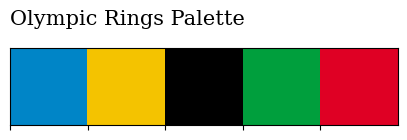

In [37]:
# Define the Olympic ring colors
olympic_colors = ['#0085C7', '#F4C300', '#000000', '#009F3D', '#DF0024']  # Blue, Yellow, Black, Green, Red

sns.palplot(olympic_colors)
plt.title("Olympic Rings Palette", loc='left', fontfamily='serif', fontsize=15, y=1.2)
plt.show()

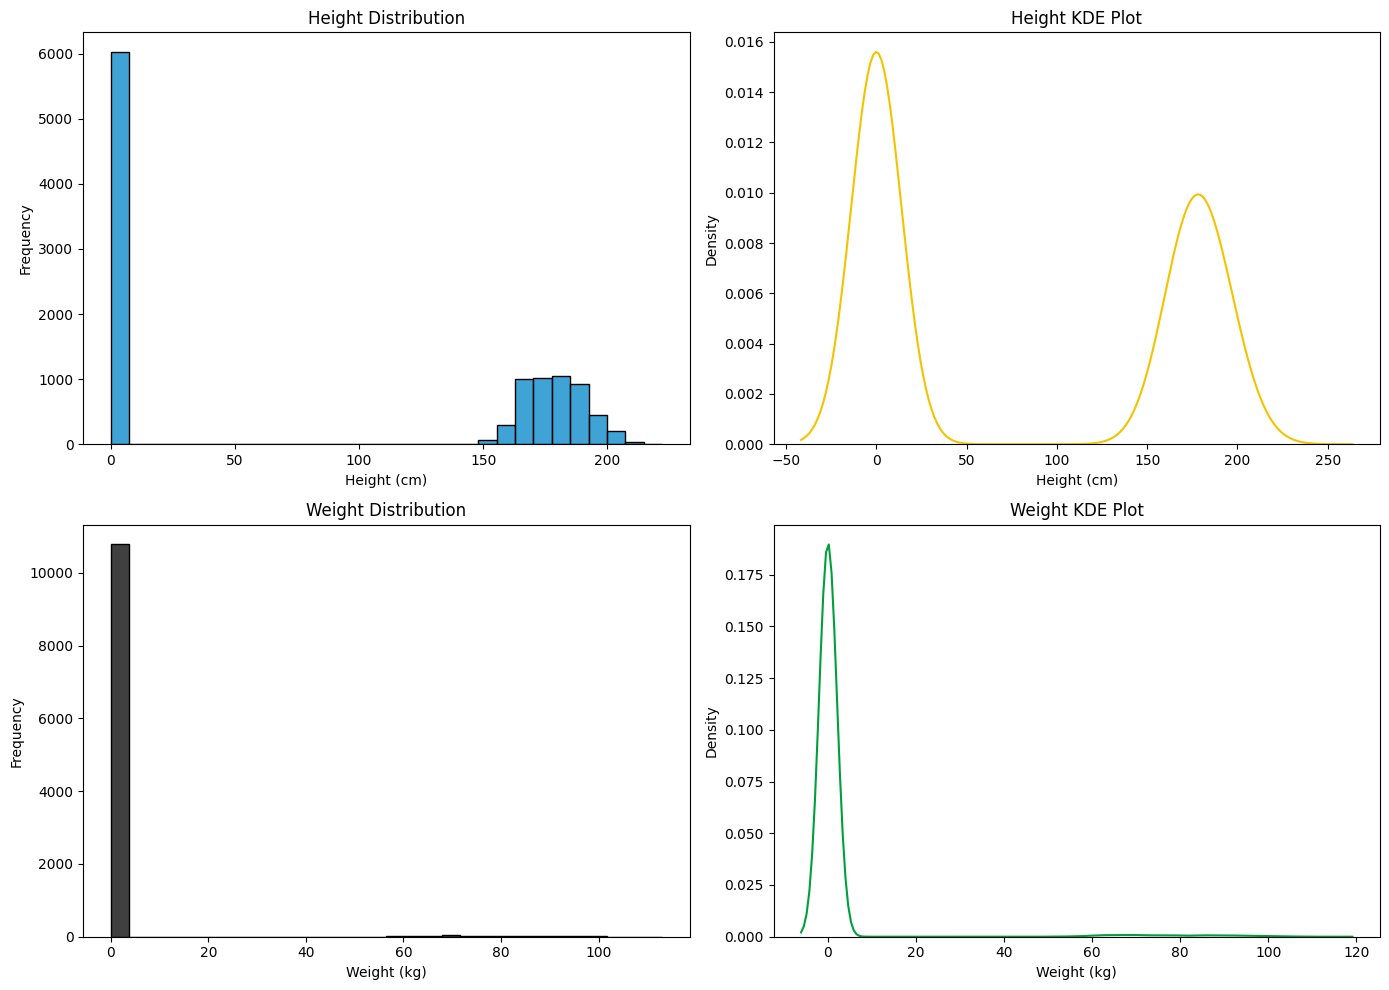

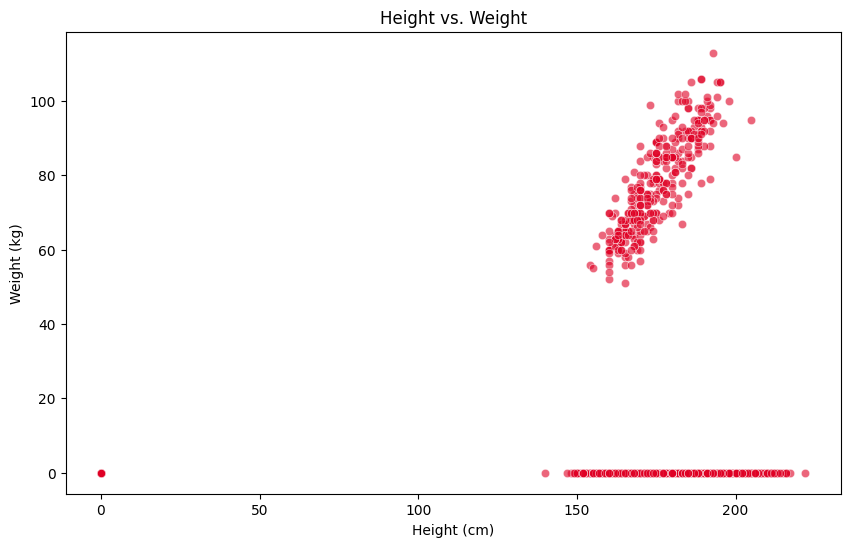

In [38]:
# Drop rows with NaN values in height or weight
athletes = athletes.dropna(subset=['height', 'weight'])

# Set up the figure and axes
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Histogram for height
sns.histplot(athletes['height'], bins=30, kde=False, ax=axs[0, 0], color=olympic_colors[0])
axs[0, 0].set_title('Height Distribution')
axs[0, 0].set_xlabel('Height (cm)')
axs[0, 0].set_ylabel('Frequency')

# KDE plot for height
sns.kdeplot(athletes['height'], ax=axs[0, 1], color=olympic_colors[1])
axs[0, 1].set_title('Height KDE Plot')
axs[0, 1].set_xlabel('Height (cm)')
axs[0, 1].set_ylabel('Density')

# Histogram for weight
sns.histplot(athletes['weight'], bins=30, kde=False, ax=axs[1, 0], color=olympic_colors[2])
axs[1, 0].set_title('Weight Distribution')
axs[1, 0].set_xlabel('Weight (kg)')
axs[1, 0].set_ylabel('Frequency')

# KDE plot for weight
sns.kdeplot(athletes['weight'], ax=axs[1, 1], color=olympic_colors[3])
axs[1, 1].set_title('Weight KDE Plot')
axs[1, 1].set_xlabel('Weight (kg)')
axs[1, 1].set_ylabel('Density')

# Adjust layout
plt.tight_layout()
plt.show()

# Scatter plot for height vs. weight
plt.figure(figsize=(10, 6))
sns.scatterplot(data=athletes, x='height', y='weight', alpha=0.6, color=olympic_colors[4])
plt.title('Height vs. Weight')
plt.xlabel('Height (cm)')
plt.ylabel('Weight (kg)')
plt.show()

In [39]:
athletes['birth_date'].head()

0    1991-10-21
1    1999-01-22
2    1996-12-21
3    1999-11-22
4    1999-10-27
Name: birth_date, dtype: object

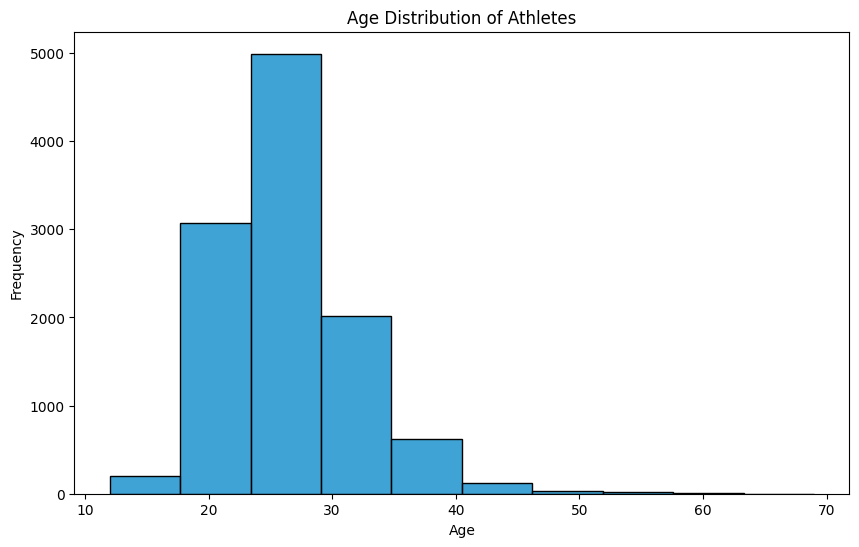

In [40]:
# Convert birth_date to datetime format
athletes['birth_date'] = pd.to_datetime(athletes['birth_date'])

# Calculate age of each athlete
def calculate_age(birth_date):
    today = datetime.today()
    age = today.year - birth_date.year - ((today.month, today.day) < (birth_date.month, birth_date.day))
    return age

athletes['age'] = athletes['birth_date'].apply(calculate_age)

# Plot the age distribution
plt.figure(figsize=(10, 6))
sns.histplot(athletes['age'], bins=10, kde=False, color='#0085C7')  # Using one of the Olympic colors
plt.title('Age Distribution of Athletes')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

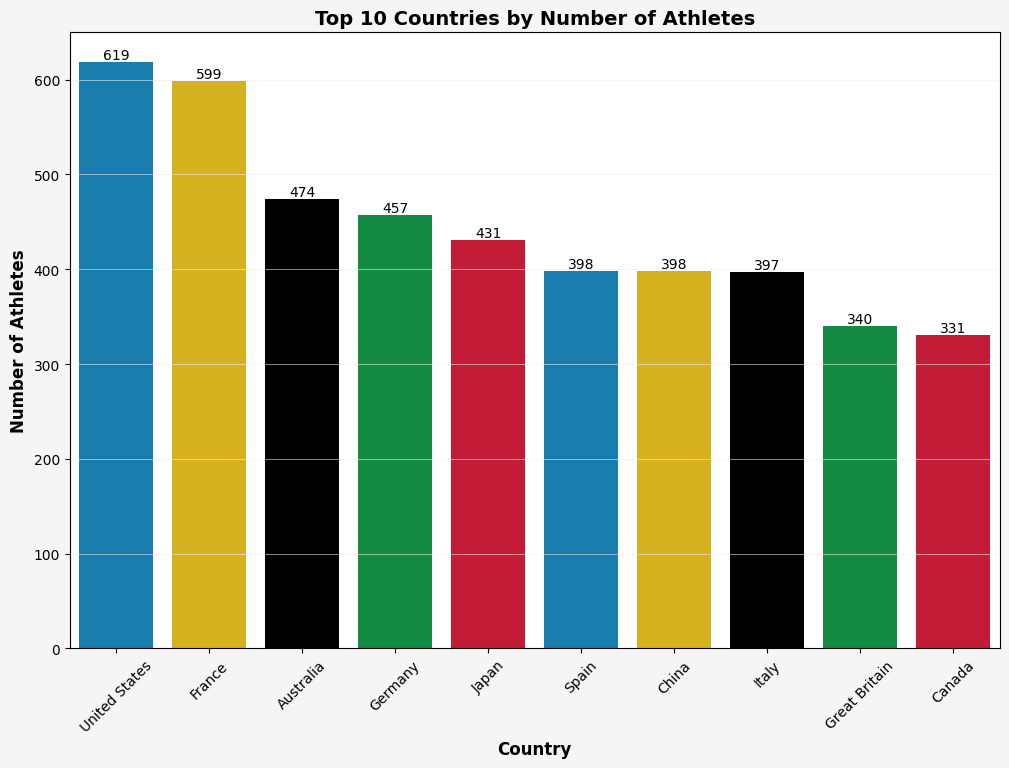

In [41]:
# Count the number of athletes from each country
country_counts = athletes['country'].value_counts()

# Select the top 10 countries based on athlete count
top_10_countries = country_counts.nlargest(10)

# Plot the bar chart for number of athletes by top 10 countries
plt.figure(figsize=(12, 8), facecolor='#f6f5f5')

# Create the bar plot with the Olympic color palette
ax = sns.barplot(x=top_10_countries.index, y=top_10_countries.values, palette=olympic_colors)

# Customize the plot
ax.set_xlabel('Country', fontsize=12, weight='bold')
ax.set_ylabel('Number of Athletes', fontsize=12, weight='bold')
ax.set_title('Top 10 Countries by Number of Athletes', fontsize=14, weight='bold')

ax.grid(which='major', axis='y', color='#EEEEEE', linewidth=0.4)

# Add the value labels
for p in ax.patches:
    value = f'{p.get_height():.0f}'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.text(x, y, value, ha='center', va='bottom', fontsize=10)

plt.xticks(rotation=45)
plt.show()

In [42]:
gender = athletes['gender']

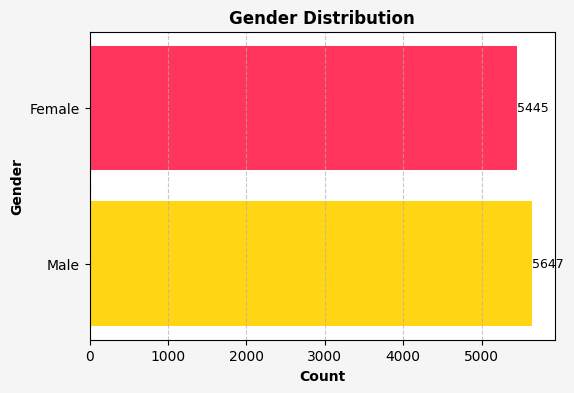

In [43]:
# Count the number of occurrences of each gender
gender_counts = gender.value_counts()

# Plot the horizontal bar chart
plt.figure(figsize=(6, 4), facecolor='#f6f5f5')

# Plot horizontal bar chart
plt.barh(gender_counts.index, gender_counts.values, color=['#ffd514', '#ff355d'])

# Add labels and title
plt.xlabel('Count', fontsize=10, weight='bold')
plt.ylabel('Gender', fontsize=10, weight='bold')
plt.title('Gender Distribution', fontsize=12, weight='bold')

# Add value labels to bars
for index, value in enumerate(gender_counts.values):
    plt.text(value, index, f'{value}', va='center', fontsize=9, color='black')

plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

In [44]:
teams = pd.read_csv("/Users/iveshe/Library/Mobile Documents/com~apple~CloudDocs/project/4/teams.csv")
discipline_counts = teams['discipline']

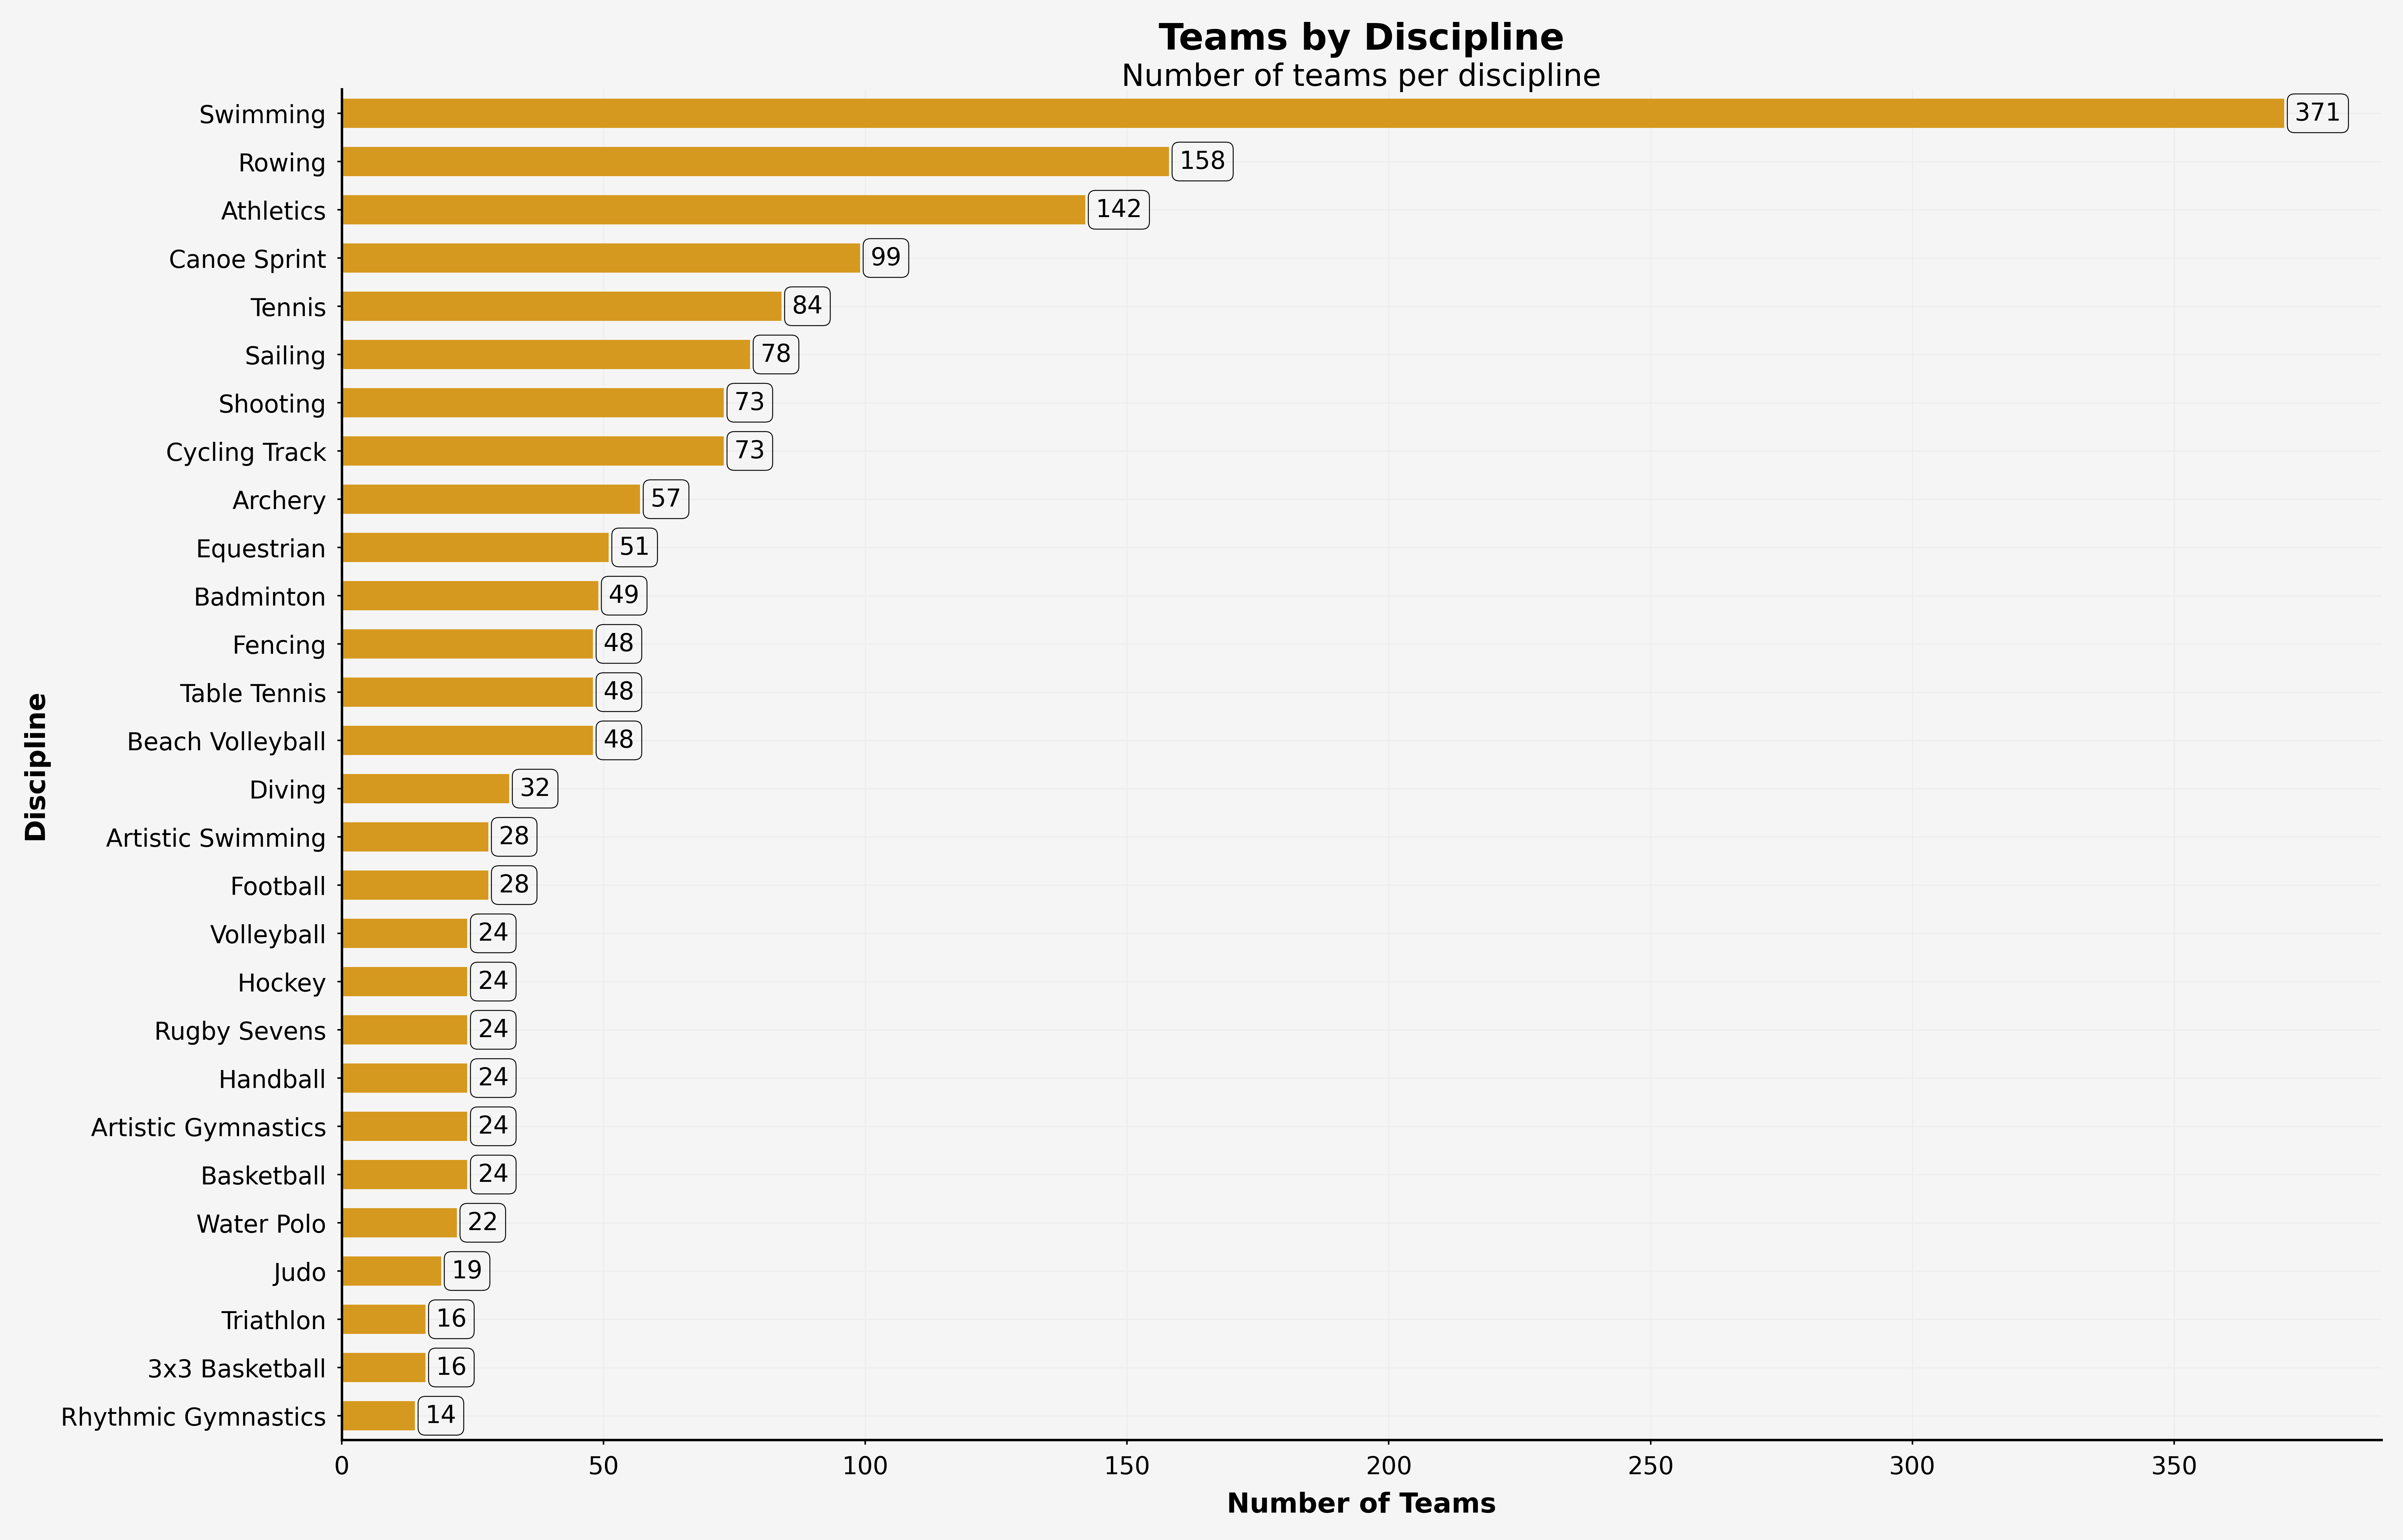

In [45]:
# Count the number of teams by discipline
discipline_counts = teams['discipline'].value_counts()

# Plot horizontal bar chart
plt.rcParams['figure.dpi'] = 600

fig = plt.figure(figsize=(12, 8), facecolor='#f6f5f5')
gs = fig.add_gridspec(1, 1)
gs.update(wspace=1.5, hspace=0.05)

background_color = "#f6f5f5"
sns.set_palette(sns.color_palette([
    '#f5a300', '#d73c45', '#5c5b5b', '#009B77', '#F4A300',
    '#00A3E0', '#C8102E', '#E5E5E5', '#007A33', '#F9A11B'
]))
ax0 = fig.add_subplot(gs[0, 0])

for s in ["right", "top"]:
    ax0.spines[s].set_visible(False)

ax0.set_facecolor(background_color)

# Bar plot for number of teams by discipline
ax0_sns = sns.barplot(y=discipline_counts.index, x=discipline_counts.values, ax=ax0, zorder=2, width=0.6)
ax0_sns.set_xlabel('Number of Teams', fontsize=9, weight='bold')
ax0_sns.set_ylabel('Discipline', fontsize=9, weight='bold')

ax0_sns.grid(which='major', axis='x', zorder=0, color='#EEEEEE', linewidth=0.4)
ax0_sns.grid(which='major', axis='y', zorder=0, color='#EEEEEE', linewidth=0.4)

ax0_sns.tick_params(labelsize=8, width=0.5, length=1.5)

# Annotate bars with counts
for p in ax0_sns.patches:
    value = f'{p.get_width():.0f}'
    x = p.get_x() + p.get_width() + 2
    y = p.get_y() + p.get_height() / 2 
    ax0.text(x, y, value, ha='left', va='center', fontsize=8, 
             bbox=dict(facecolor='none', edgecolor='black', boxstyle='round', linewidth=0.3))

# Title and annotations
ax0_sns.text(0.5, 1.05, 'Teams by Discipline', fontsize=12, weight='bold', ha='center', va='top', transform=ax0.transAxes)
ax0_sns.text(0.5, 1.02, 'Number of teams per discipline', fontsize=10, ha='center', va='top', transform=ax0.transAxes)

plt.show()

In [46]:
schedule = pd.read_csv("/Users/iveshe/Library/Mobile Documents/com~apple~CloudDocs/project/4/schedules.csv")
schedule.head()

start_date                   end_date         day    status  \
0  2024-07-24T15:00:00+02:00  2024-07-24T16:45:00+02:00  2024-07-24  FINISHED   
1  2024-07-24T15:00:00+02:00  2024-07-24T16:45:00+02:00  2024-07-24  FINISHED   
2  2024-07-24T15:30:00+02:00  2024-07-24T15:46:00+02:00  2024-07-24  FINISHED   
3  2024-07-24T16:00:00+02:00  2024-07-24T16:16:00+02:00  2024-07-24  FINISHED   
4  2024-07-24T16:30:00+02:00  2024-07-24T16:46:00+02:00  2024-07-24  FINISHED   

     discipline discipline_code event  event_medal          phase gender  \
0      Football             FBL   Men            0  Men's Group B      M   
1      Football             FBL   Men            0  Men's Group C      M   
2  Rugby Sevens             RU7   Men            0   Men's Pool B      M   
3  Rugby Sevens             RU7   Men            0   Men's Pool B      M   
4  Rugby Sevens             RU7   Men            0   Men's Pool C      M   

  event_type                      venue venue_code  \
0      HTEAM  Geoffroy-Guichard Stadium        STE   
1      HTEAM           Parc des Princes        PDP   
2      HTEAM            Stade de France        STA   
3      HTEAM            Stade de France        STA   
4      HTEAM            Stade de France        STA   

                       location_description location_code  \
0  Geoffroy-Guichard Stadium, Saint-Etienne           STE   
1                   Parc des Princes, Paris           PDP   
2                           Stade de France           STA   
3                           Stade de France           STA   
4                           Stade de France           STA   

                                                 url  
0   /en/paris-2024/results/football/men/gpb-000100--  
1   /en/paris-2024/results/football/men/gpc-000100--  
2  /en/paris-2024/results/rugby-sevens/men/gpb-00...  
3  /en/paris-2024/results/rugby-sevens/men/gpb-00...  
4  /en/paris-2024/results/rugby-sevens/men/gpc-00...

In [47]:
schedule.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3895 entries, 0 to 3894
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   start_date            3895 non-null   object
 1   end_date              3893 non-null   object
 2   day                   3895 non-null   object
 3   status                3895 non-null   object
 4   discipline            3895 non-null   object
 5   discipline_code       3895 non-null   object
 6   event                 3893 non-null   object
 7   event_medal           3895 non-null   int64 
 8   phase                 3893 non-null   object
 9   gender                3893 non-null   object
 10  event_type            3893 non-null   object
 11  venue                 3893 non-null   object
 12  venue_code            3893 non-null   object
 13  location_description  3893 non-null   object
 14  location_code         3893 non-null   object
 15  url                   3810 non-null   

In [48]:
schedule['start_date'] = pd.to_datetime(schedule['start_date'])
schedule['end_date'] = pd.to_datetime(schedule['end_date'])

# Extract date part for aggregation
schedule['date'] = schedule['start_date'].dt.date

event_counts = schedule.groupby('date').size().reset_index(name='event_count')

# Plotting the timeline of events
fig = px.line(event_counts, x='date', y='event_count', 
              title='Olympics Event Timeline',
              labels={'date': 'Date', 'event_count': 'Number of Events'},
              markers=True)

fig.update_layout(
    xaxis_title="Date",
    yaxis_title="Number of Events",
    title_x=0.5,
    template='plotly_white'
)

fig.show()

In [49]:
prime_time_start = pd.to_datetime('19:00:00').time()
prime_time_end = pd.to_datetime('23:00:00').time()
schedule['start_time'] = pd.to_datetime(schedule['start_date']).dt.time

prime_time_events = schedule[(schedule['start_time'] >= prime_time_start) & 
                             (schedule['start_time'] <= prime_time_end)]

prime_time_by_discipline = prime_time_events['discipline'].value_counts()
prime_time_by_day = prime_time_events['day'].value_counts()

print("Prime Time Events by Discipline:")
print(prime_time_by_discipline)

print("\nPrime Time Events by Day:")
print(prime_time_by_day)

fig1 = px.bar(prime_time_by_discipline, x=prime_time_by_discipline.index, y=prime_time_by_discipline.values,
              title="Prime Time Events by Discipline",
              labels={'x': 'Discipline', 'y': 'Number of Events'},
              color_discrete_sequence=['#FFD700', '#C0C0C0', '#CD7F32'])

fig1.update_layout(
    xaxis_title="Discipline",
    yaxis_title="Number of Events",
    template="plotly_white"
)

# Bar plot for Prime Time Events by Day
fig2 = px.bar(prime_time_by_day, x=prime_time_by_day.index, y=prime_time_by_day.values,
              title="Prime Time Events by Day",
              labels={'x': 'Day', 'y': 'Number of Events'},
              color_discrete_sequence=['#FFD700', '#C0C0C0', '#CD7F32'])

fig2.update_layout(
    xaxis_title="Day",
    yaxis_title="Number of Events",
    template="plotly_white"
)

# Show plots
fig1.show()
fig2.show()

Prime Time Events by Discipline:
discipline
Boxing                   98
Athletics                68
Table Tennis             56
Badminton                55
Swimming                 54
Wrestling                50
Taekwondo                40
Beach Volleyball         38
Fencing                  36
3x3 Basketball           31
Football                 30
Surfing                  29
Rugby Sevens             28
Cycling Track            28
Handball                 24
Water Polo               22
Hockey                   20
Cycling BMX Racing       16
Breaking                 16
Basketball               14
Tennis                   14
Archery                  13
Volleyball               13
Artistic Swimming         5
Weightlifting             4
Sailing                   2
Artistic Gymnastics       2
Trampoline Gymnastics     1
Opening Ceremony          1
Modern Pentathlon         1
Closing Ceremony          1
Name: count, dtype: int64

Prime Time Events by Day:
day
2024-07-27    78
2024-07-28    

In [50]:
medals = pd.read_csv("/Users/iveshe/Library/Mobile Documents/com~apple~CloudDocs/project/4/medals_total.csv")
medals.head()

country_code  Gold Medal  Silver Medal  Bronze Medal  Total
0          USA          40            44            42    126
1          CHN          40            27            24     91
2          JPN          20            12            13     45
3          AUS          18            19            16     53
4          FRA          16            26            22     64

In [51]:
medals.columns

Index(['country_code', 'Gold Medal', 'Silver Medal', 'Bronze Medal', 'Total'], dtype='object')

In [52]:
plt.rcParams['figure.dpi'] = 600

fig = plt.figure(figsize=(30, 12), facecolor='#f6f5f5')
gs = fig.add_gridspec(1, 1)
gs.update(wspace=1.5, hspace=0.05)

background_color = "#f6f5f5"
sns.set_palette(['#FFD700', '#C0C0C0', '#CD7F32'])
ax0 = fig.add_subplot(gs[0, 0])

for s in ["right", "top"]:
    ax0.spines[s].set_visible(False)
    
ax0.set_facecolor(background_color)

# Convert to vertical bar plot
ax0_sns = medals.plot(x='country_code', y=['Gold Medal', 'Silver Medal', 'Bronze Medal'], kind='bar', ax=ax0, zorder=2, width=0.8)

ax0_sns.set_xlabel('Team Name', fontsize=10, weight='bold')
ax0_sns.set_ylabel('Medals Count', fontsize=10, weight='bold')

ax0_sns.grid(which='major', axis='y', zorder=0, color='#EEEEEE', linewidth=0.4)
ax0_sns.grid(which='major', axis='x', zorder=0, color='#EEEEEE', linewidth=0.4)

ax0_sns.tick_params(labelsize=8, width=0.5, length=1.5)

ax0_sns.legend(['Gold', 'Silver', 'Bronze'], ncol=3, facecolor='#D8D8D8', edgecolor=background_color, fontsize=8, bbox_to_anchor=(1.005, 1), loc='upper right')

for p in ax0_sns.patches:
    value = f'{p.get_height():.0f}'
    if value == '0':
        pass
    else:
        x = p.get_x() + p.get_width() / 2
        y = p.get_y() + p.get_height() + 1
        ax0.text(x, y, value, ha='center', va='bottom', fontsize=8)

Xstart, Xend = ax0.get_xlim()
Ystart, Yend = ax0.get_ylim()

ax0_sns.text(Xend, Yend + 0.05*Yend, 'Medals Plot', fontsize=12, weight='bold', ha='right')
ax0.text(Xend, Yend, 'Medals as on 10th August 2024', fontsize=10, ha='right')

plt.show()

In [53]:
medals_data = medals[['country_code', 'Gold Medal', 'Silver Medal', 'Bronze Medal']]
medals_data = medals_data.set_index('country_code').sort_values(by=['Gold Medal', 'Silver Medal', 'Bronze Medal'], ascending=False)

fig = go.Figure()

fig.add_trace(go.Bar(
    x=medals_data.index,
    y=medals_data['Gold Medal'],
    name='Gold',
    marker_color='#FFD700'
))

fig.add_trace(go.Bar(
    x=medals_data.index,
    y=medals_data['Silver Medal'],
    name='Silver',
    marker_color='#C0C0C0'
))

fig.add_trace(go.Bar(
    x=medals_data.index,
    y=medals_data['Bronze Medal'],
    name='Bronze',
    marker_color='#CD7F32'
))

# Customize layout
fig.update_layout(
    barmode='stack',
    xaxis_title='Team Name',
    yaxis_title='Medals Count',
    title='Medals Plot',
    plot_bgcolor='#f6f5f5',
    legend=dict(
        orientation='h',
        yanchor='bottom',
        y=1.02,
        xanchor='right',
        x=1
    ),
    font=dict(size=20),
)

for idx, country in enumerate(medals_data.index):
    for medal, color in zip(['Gold Medal', 'Silver Medal', 'Bronze Medal'], ['#FFD700', '#C0C0C0', '#CD7F32']):
        count = medals_data.at[country, medal]
        if count > 0:
            fig.add_annotation(
                x=country,
                y=sum(medals_data.loc[country, ['Gold Medal', 'Silver Medal', 'Bronze Medal']][medals_data.columns.get_loc(medal):]),
                text=str(count),
                showarrow=False,
                font=dict(color='black', size=12),
                xanchor='center'
            )

fig.show()

for idx, country in enumerate(medals_data.index):
    for medal, color in zip(['Gold Medal', 'Silver Medal', 'Bronze Medal'], ['#FFD700', '#C0C0C0', '#CD7F32']):
        count = medals_data.at[country, medal]
        if count > 0:
            fig.add_annotation(
                x=country,
                y=sum(medals_data.loc[country, ['Gold Medal', 'Silver Medal', 'Bronze Medal']][medals_data.columns.get_loc(medal):]),
                text=str(count),
                showarrow=False,
                font=dict(color='black', size=10),
                xanchor='center',
                yshift=5 
            )

In [54]:
events = pd.read_csv('/Users/iveshe/Library/Mobile Documents/com~apple~CloudDocs/project/4/events.csv')

In [55]:
events['sport'].value_counts()

sport
Athletics                48
Swimming                 35
Wrestling                18
Judo                     15
Shooting                 15
Rowing                   14
Artistic Gymnastics      14
Boxing                   13
Fencing                  12
Cycling Track            12
Canoe Sprint             10
Sailing                  10
Weightlifting            10
Taekwondo                 8
Diving                    8
Canoe Slalom              6
Equestrian                6
Table Tennis              5
Tennis                    5
Archery                   5
Badminton                 5
Skateboarding             4
Sport Climbing            4
Cycling Road              4
Triathlon                 3
Artistic Swimming         2
Water Polo                2
Volleyball                2
Trampoline                2
Basketball                2
Basketball 3x3            2
Beach Volleyball          2
Surfing                   2
Football                  2
Golf                      2
Breaking      

<Axes: xlabel='sport'>

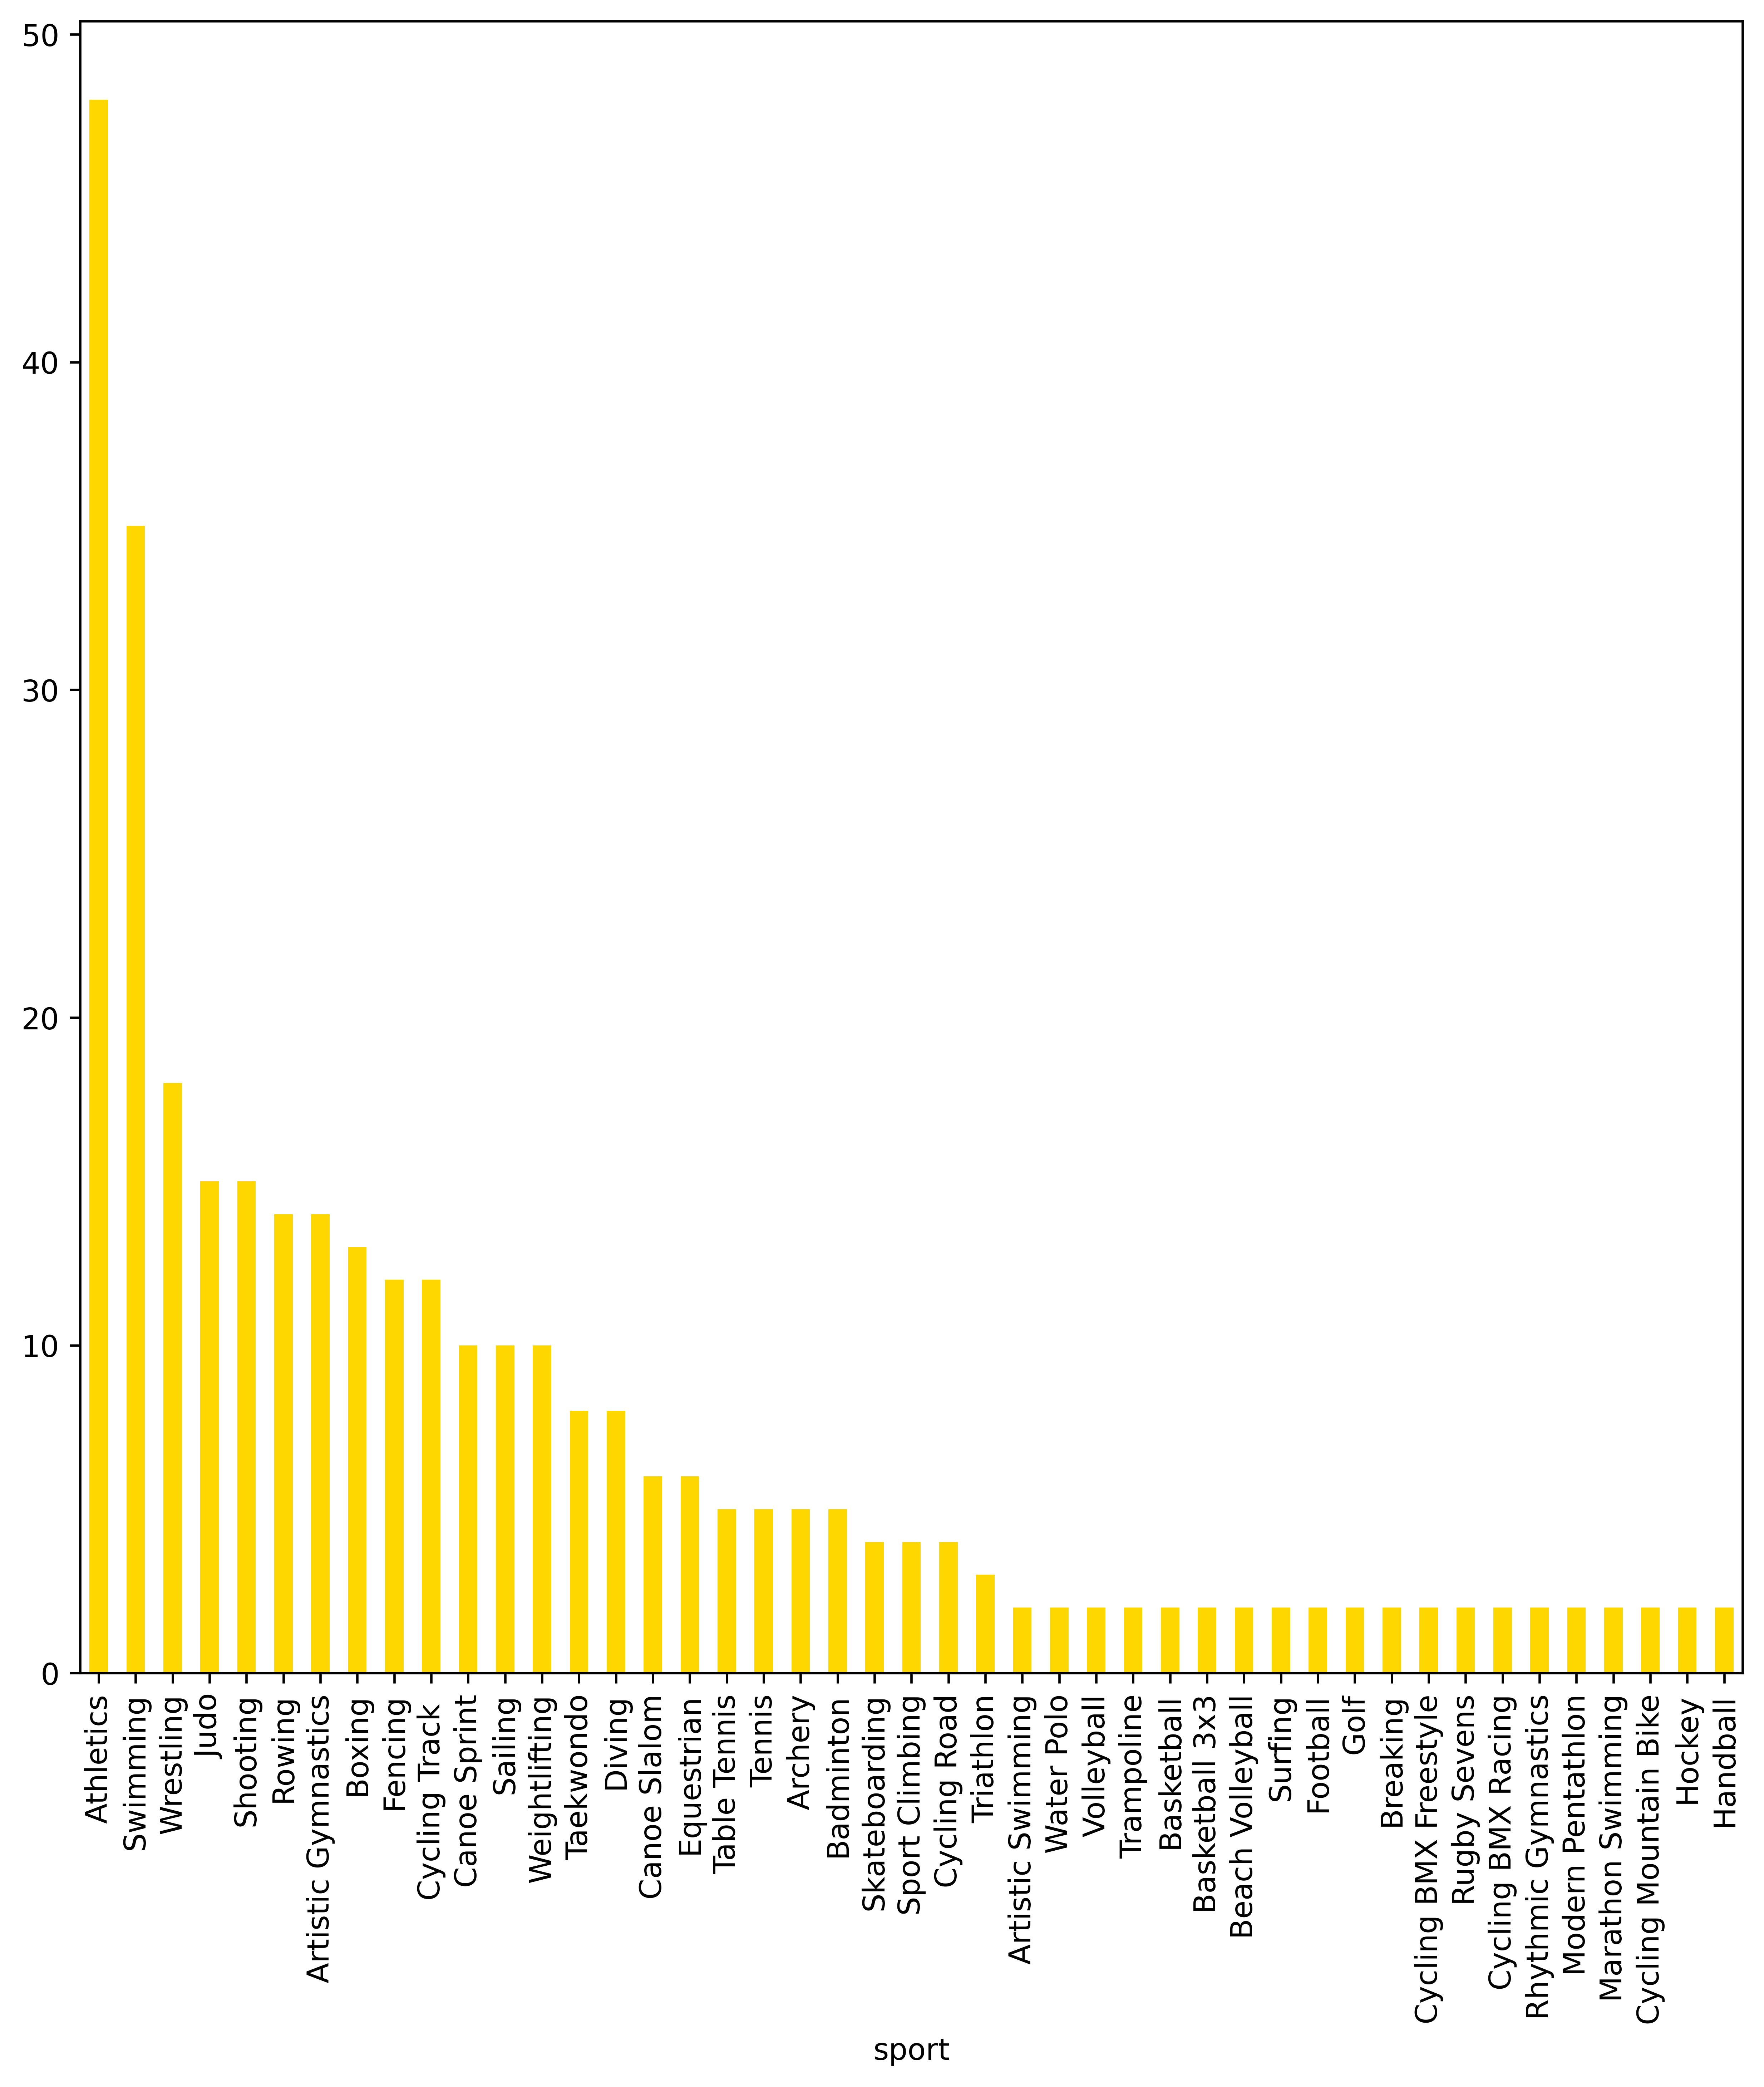

In [56]:
import matplotlib.pyplot as plt
events['sport'].value_counts().plot.bar(figsize=(10,10))

In [57]:
gender_tf = []
for y in events['event'].apply(lambda x: x.lower()) :
    if 'women' in y or 'girl' in y:
        gender_tf.append('women')
    elif 'men' in y or 'boy' in y:
        gender_tf.append('men')
    else:
        gender_tf.append('mixed/non-gendered')
gender_tf = pd.Series(gender_tf)

In [58]:
events['gender'] = gender_tf

In [59]:
event_grouped = events.groupby(['sport', 'gender'])['event'].count()

In [60]:
event_grouped

sport                gender            
Archery              men                    2
                     mixed/non-gendered     1
                     women                  2
Artistic Gymnastics  men                    8
                     women                  6
                                           ..
Water Polo           women                  1
Weightlifting        men                    5
                     women                  5
Wrestling            men                   12
                     women                  6
Name: event, Length: 97, dtype: int64

In [61]:
event_grouped.unstack().plot(kind='bar', figsize=(20,20))

<Axes: xlabel='sport'>

In [62]:
events[(events['sport']=='Wrestling')&(events['gender']=='men')]

event        tag      sport sport_code  \
311   Men's Greco-Roman 60kg  wrestling  Wrestling        WRE   
312   Men's Greco-Roman 67kg  wrestling  Wrestling        WRE   
313   Men's Greco-Roman 77kg  wrestling  Wrestling        WRE   
314   Men's Greco-Roman 87kg  wrestling  Wrestling        WRE   
315   Men's Greco-Roman 97kg  wrestling  Wrestling        WRE   
316  Men's Greco-Roman 130kg  wrestling  Wrestling        WRE   
323     Men's Freestyle 57kg  wrestling  Wrestling        WRE   
324     Men's Freestyle 65kg  wrestling  Wrestling        WRE   
325     Men's Freestyle 74kg  wrestling  Wrestling        WRE   
326     Men's Freestyle 86kg  wrestling  Wrestling        WRE   
327     Men's Freestyle 97kg  wrestling  Wrestling        WRE   
328    Men's Freestyle 125kg  wrestling  Wrestling        WRE   

                                             sport_url gender  
311  https://olympics.com/en/paris-2024/sports/wres...    men  
312  https://olympics.com/en/paris-2024/sports/wres...    men  
313  https://olympics.com/en/paris-2024/sports/wres...    men  
314  https://olympics.com/en/paris-2024/sports/wres...    men  
315  https://olympics.com/en/paris-2024/sports/wres...    men  
316  https://olympics.com/en/paris-2024/sports/wres...    men  
323  https://olympics.com/en/paris-2024/sports/wres...    men  
324  https://olympics.com/en/paris-2024/sports/wres...    men  
325  https://olympics.com/en/paris-2024/sports/wres...    men  
326  https://olympics.com/en/paris-2024/sports/wres...    men  
327  https://olympics.com/en/paris-2024/sports/wres...    men  
328  https://olympics.com/en/paris-2024/sports/wres...    men

In [63]:
events[(events['sport']=='Wrestling')&(events['gender']=='women')]

event        tag      sport sport_code  \
317  Women's Freestyle 50kg  wrestling  Wrestling        WRE   
318  Women's Freestyle 53kg  wrestling  Wrestling        WRE   
319  Women's Freestyle 57kg  wrestling  Wrestling        WRE   
320  Women's Freestyle 62kg  wrestling  Wrestling        WRE   
321  Women's Freestyle 68kg  wrestling  Wrestling        WRE   
322  Women's Freestyle 76kg  wrestling  Wrestling        WRE   

                                             sport_url gender  
317  https://olympics.com/en/paris-2024/sports/wres...  women  
318  https://olympics.com/en/paris-2024/sports/wres...  women  
319  https://olympics.com/en/paris-2024/sports/wres...  women  
320  https://olympics.com/en/paris-2024/sports/wres...  women  
321  https://olympics.com/en/paris-2024/sports/wres...  women  
322  https://olympics.com/en/paris-2024/sports/wres...  women

In [64]:
events[(events['sport']=='Artistic Gymnastics')&(events['gender']=='men')]

event                  tag                sport sport_code  \
5       Men's All-Around  artistic-gymnastics  Artistic Gymnastics        GAR   
6   Men's Floor Exercise  artistic-gymnastics  Artistic Gymnastics        GAR   
7     Men's Pommel Horse  artistic-gymnastics  Artistic Gymnastics        GAR   
8            Men's Rings  artistic-gymnastics  Artistic Gymnastics        GAR   
9            Men's Vault  artistic-gymnastics  Artistic Gymnastics        GAR   
10   Men's Parallel Bars  artistic-gymnastics  Artistic Gymnastics        GAR   
11  Men's Horizontal Bar  artistic-gymnastics  Artistic Gymnastics        GAR   
12            Men's Team  artistic-gymnastics  Artistic Gymnastics        GAR   

                                            sport_url gender  
5   https://olympics.com/en/paris-2024/sports/arti...    men  
6   https://olympics.com/en/paris-2024/sports/arti...    men  
7   https://olympics.com/en/paris-2024/sports/arti...    men  
8   https://olympics.com/en/paris-2024/sports/arti...    men  
9   https://olympics.com/en/paris-2024/sports/arti...    men  
10  https://olympics.com/en/paris-2024/sports/arti...    men  
11  https://olympics.com/en/paris-2024/sports/arti...    men  
12  https://olympics.com/en/paris-2024/sports/arti...    men

In [65]:
events[(events['sport']=='Artistic Gymnastics')&(events['gender']=='women')]

event                  tag                sport  \
13      Women's All-Around  artistic-gymnastics  Artistic Gymnastics   
14           Women's Vault  artistic-gymnastics  Artistic Gymnastics   
15     Women's Uneven Bars  artistic-gymnastics  Artistic Gymnastics   
16    Women's Balance Beam  artistic-gymnastics  Artistic Gymnastics   
17  Women's Floor Exercise  artistic-gymnastics  Artistic Gymnastics   
18            Women's Team  artistic-gymnastics  Artistic Gymnastics   

   sport_code                                          sport_url gender  
13        GAR  https://olympics.com/en/paris-2024/sports/arti...  women  
14        GAR  https://olympics.com/en/paris-2024/sports/arti...  women  
15        GAR  https://olympics.com/en/paris-2024/sports/arti...  women  
16        GAR  https://olympics.com/en/paris-2024/sports/arti...  women  
17        GAR  https://olympics.com/en/paris-2024/sports/arti...  women  
18        GAR  https://olympics.com/en/paris-2024/sports/arti...  women

In [66]:
events[(events['sport']=='Boxing')&(events['gender']=='men')]

event     tag   sport sport_code  \
80    Men's 51kg  boxing  Boxing        BOX   
81    Men's 57kg  boxing  Boxing        BOX   
82  Men's 63.5kg  boxing  Boxing        BOX   
83    Men's 71kg  boxing  Boxing        BOX   
84    Men's 80kg  boxing  Boxing        BOX   
85    Men's 92kg  boxing  Boxing        BOX   
86   Men's +92kg  boxing  Boxing        BOX   

                                           sport_url gender  
80  https://olympics.com/en/paris-2024/sports/boxing    men  
81  https://olympics.com/en/paris-2024/sports/boxing    men  
82  https://olympics.com/en/paris-2024/sports/boxing    men  
83  https://olympics.com/en/paris-2024/sports/boxing    men  
84  https://olympics.com/en/paris-2024/sports/boxing    men  
85  https://olympics.com/en/paris-2024/sports/boxing    men  
86  https://olympics.com/en/paris-2024/sports/boxing    men

In [67]:
events[(events['sport']=='Boxing')&(events['gender']=='women')]

event     tag   sport sport_code  \
87  Women's 50kg  boxing  Boxing        BOX   
88  Women's 54kg  boxing  Boxing        BOX   
89  Women's 57kg  boxing  Boxing        BOX   
90  Women's 60kg  boxing  Boxing        BOX   
91  Women's 66kg  boxing  Boxing        BOX   
92  Women's 75kg  boxing  Boxing        BOX   

                                           sport_url gender  
87  https://olympics.com/en/paris-2024/sports/boxing  women  
88  https://olympics.com/en/paris-2024/sports/boxing  women  
89  https://olympics.com/en/paris-2024/sports/boxing  women  
90  https://olympics.com/en/paris-2024/sports/boxing  women  
91  https://olympics.com/en/paris-2024/sports/boxing  women  
92  https://olympics.com/en/paris-2024/sports/boxing  women

In [68]:
sports_with_weightclasses = events[events['event'].apply(lambda x: 'kg' in x)]['sport'].unique()

In [69]:
sports_with_weightclasses

array(['Boxing', 'Judo', 'Taekwondo', 'Weightlifting', 'Wrestling'],
      dtype=object)

In [70]:
weight_df = events[events['sport'].isin(sports_with_weightclasses)].set_index(['sport', 'gender'])[['event']]

In [71]:
def get_num_from_string(s):
    x = ""
    for i in s:
        if i.isdigit() or i=='.': x+=i
    return float(x) if x else None

In [72]:
weight_df

event
sport     gender                       
Boxing    men                Men's 51kg
          men                Men's 57kg
          men              Men's 63.5kg
          men                Men's 71kg
          men                Men's 80kg
...                                 ...
Wrestling men      Men's Freestyle 65kg
          men      Men's Freestyle 74kg
          men      Men's Freestyle 86kg
          men      Men's Freestyle 97kg
          men     Men's Freestyle 125kg

[64 rows x 1 columns]

In [73]:
weight_df['weight'] = weight_df['event'].apply(get_num_from_string)

In [74]:
weight_df[weight_df['weight'].isna()]

event  weight
sport gender                                
Judo  mixed/non-gendered  Mixed Team     NaN

In [75]:
events[(events['sport']=='Judo')]

event   tag sport sport_code  \
167  Women -48 kg  judo  Judo        JUD   
168  Women -52 kg  judo  Judo        JUD   
169  Women -57 kg  judo  Judo        JUD   
170  Women -63 kg  judo  Judo        JUD   
171  Women -70 kg  judo  Judo        JUD   
172  Women -78 kg  judo  Judo        JUD   
173  Women +78 kg  judo  Judo        JUD   
174    Men -60 kg  judo  Judo        JUD   
175    Men -66 kg  judo  Judo        JUD   
176    Men -73 kg  judo  Judo        JUD   
177    Men -81 kg  judo  Judo        JUD   
178    Men -90 kg  judo  Judo        JUD   
179   Men -100 kg  judo  Judo        JUD   
180   Men +100 kg  judo  Judo        JUD   
181    Mixed Team  judo  Judo        JUD   

                                          sport_url              gender  
167  https://olympics.com/en/paris-2024/sports/judo               women  
168  https://olympics.com/en/paris-2024/sports/judo               women  
169  https://olympics.com/en/paris-2024/sports/judo               women  
170  https://olympics.com/en/paris-2024/sports/judo               women  
171  https://olympics.com/en/paris-2024/sports/judo               women  
172  https://olympics.com/en/paris-2024/sports/judo               women  
173  https://olympics.com/en/paris-2024/sports/judo               women  
174  https://olympics.com/en/paris-2024/sports/judo                 men  
175  https://olympics.com/en/paris-2024/sports/judo                 men  
176  https://olympics.com/en/paris-2024/sports/judo                 men  
177  https://olympics.com/en/paris-2024/sports/judo                 men  
178  https://olympics.com/en/paris-2024/sports/judo                 men  
179  https://olympics.com/en/paris-2024/sports/judo                 men  
180  https://olympics.com/en/paris-2024/sports/judo                 men  
181  https://olympics.com/en/paris-2024/sports/judo  mixed/non-gendered

In [76]:
weight_df = weight_df.dropna()

In [77]:
weight_df

event  weight
sport     gender                               
Boxing    men                Men's 51kg    51.0
          men                Men's 57kg    57.0
          men              Men's 63.5kg    63.5
          men                Men's 71kg    71.0
          men                Men's 80kg    80.0
...                                 ...     ...
Wrestling men      Men's Freestyle 65kg    65.0
          men      Men's Freestyle 74kg    74.0
          men      Men's Freestyle 86kg    86.0
          men      Men's Freestyle 97kg    97.0
          men     Men's Freestyle 125kg   125.0

[63 rows x 2 columns]

In [78]:
weight_df[weight_df['weight'].isna()]

Empty DataFrame
Columns: [event, weight]
Index: []

In [79]:
weight_df_display = weight_df[['weight']]

In [80]:
weight_df_display

weight
sport     gender        
Boxing    men       51.0
          men       57.0
          men       63.5
          men       71.0
          men       80.0
...                  ...
Wrestling men       65.0
          men       74.0
          men       86.0
          men       97.0
          men      125.0

[63 rows x 1 columns]

In [81]:
weight_df_display.loc[weight_df_display.index.unique()[0]]

weight
sport  gender        
Boxing men       51.0
       men       57.0
       men       63.5
       men       71.0
       men       80.0
       men       92.0
       men       92.0

In [82]:
weight_df_display.index.unique()

MultiIndex([(       'Boxing',   'men'),
            (       'Boxing', 'women'),
            (         'Judo', 'women'),
            (         'Judo',   'men'),
            (    'Taekwondo',   'men'),
            (    'Taekwondo', 'women'),
            ('Weightlifting', 'women'),
            ('Weightlifting',   'men'),
            (    'Wrestling',   'men'),
            (    'Wrestling', 'women')],
           names=['sport', 'gender'])

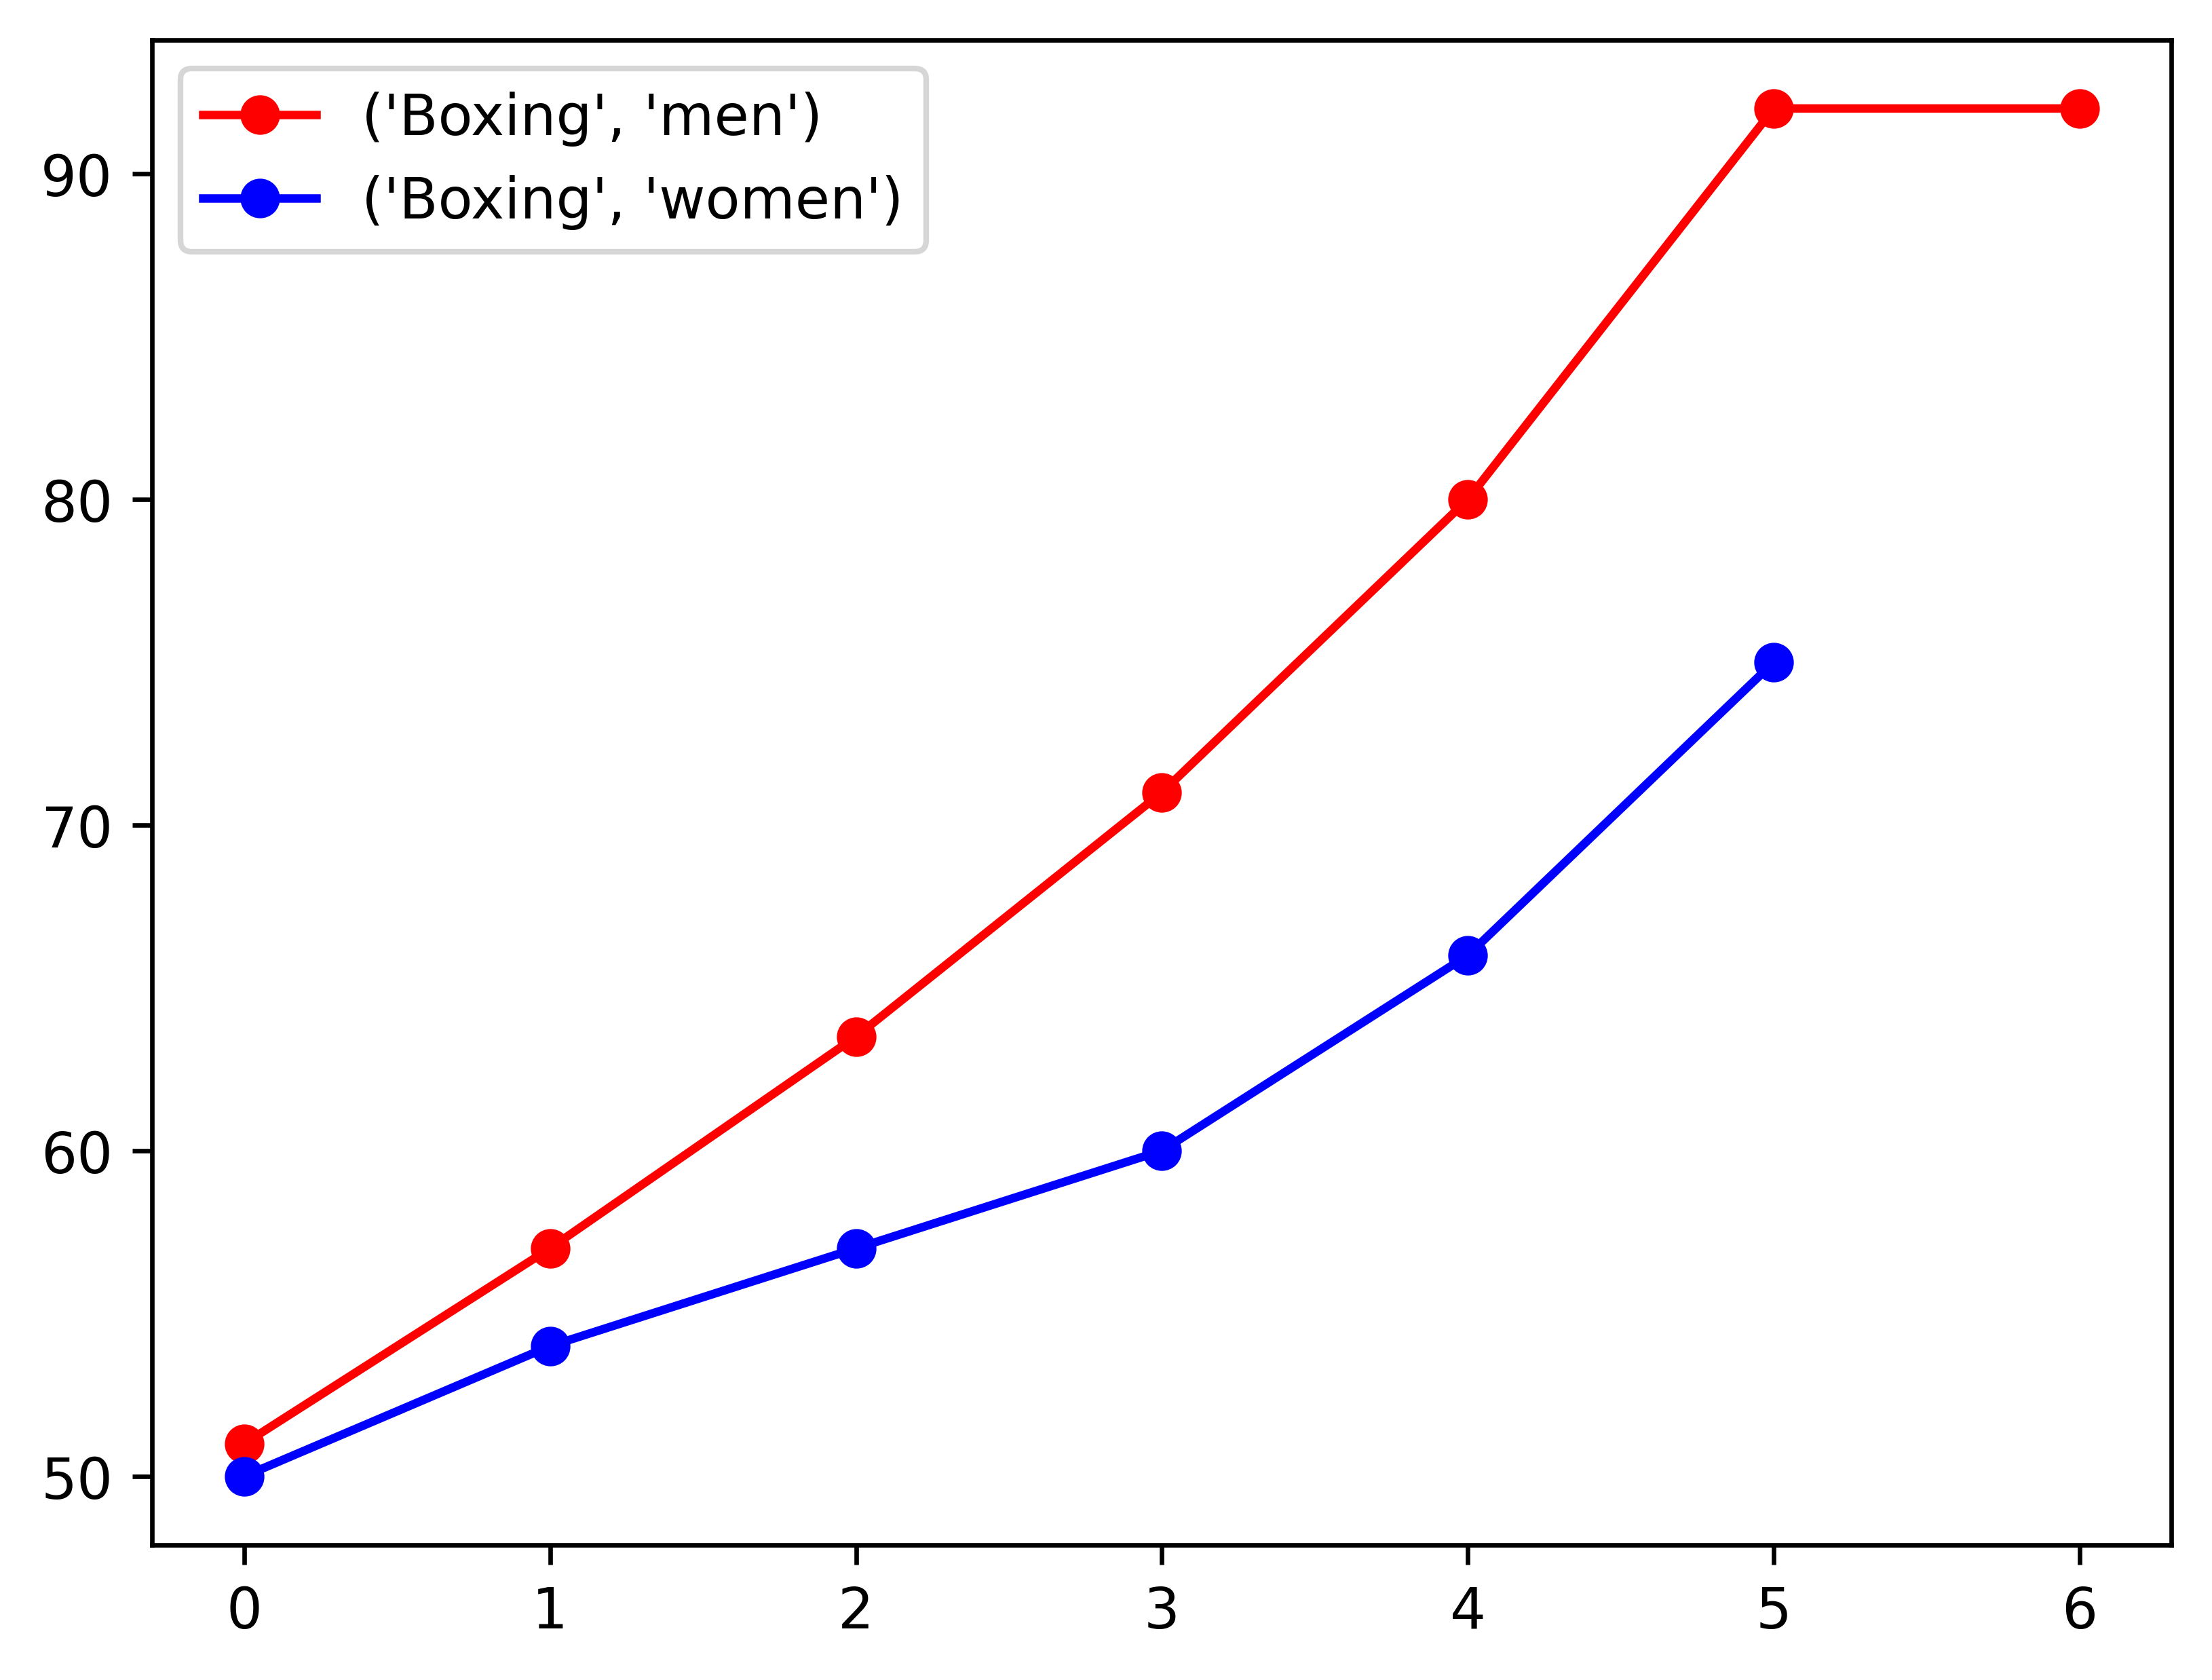

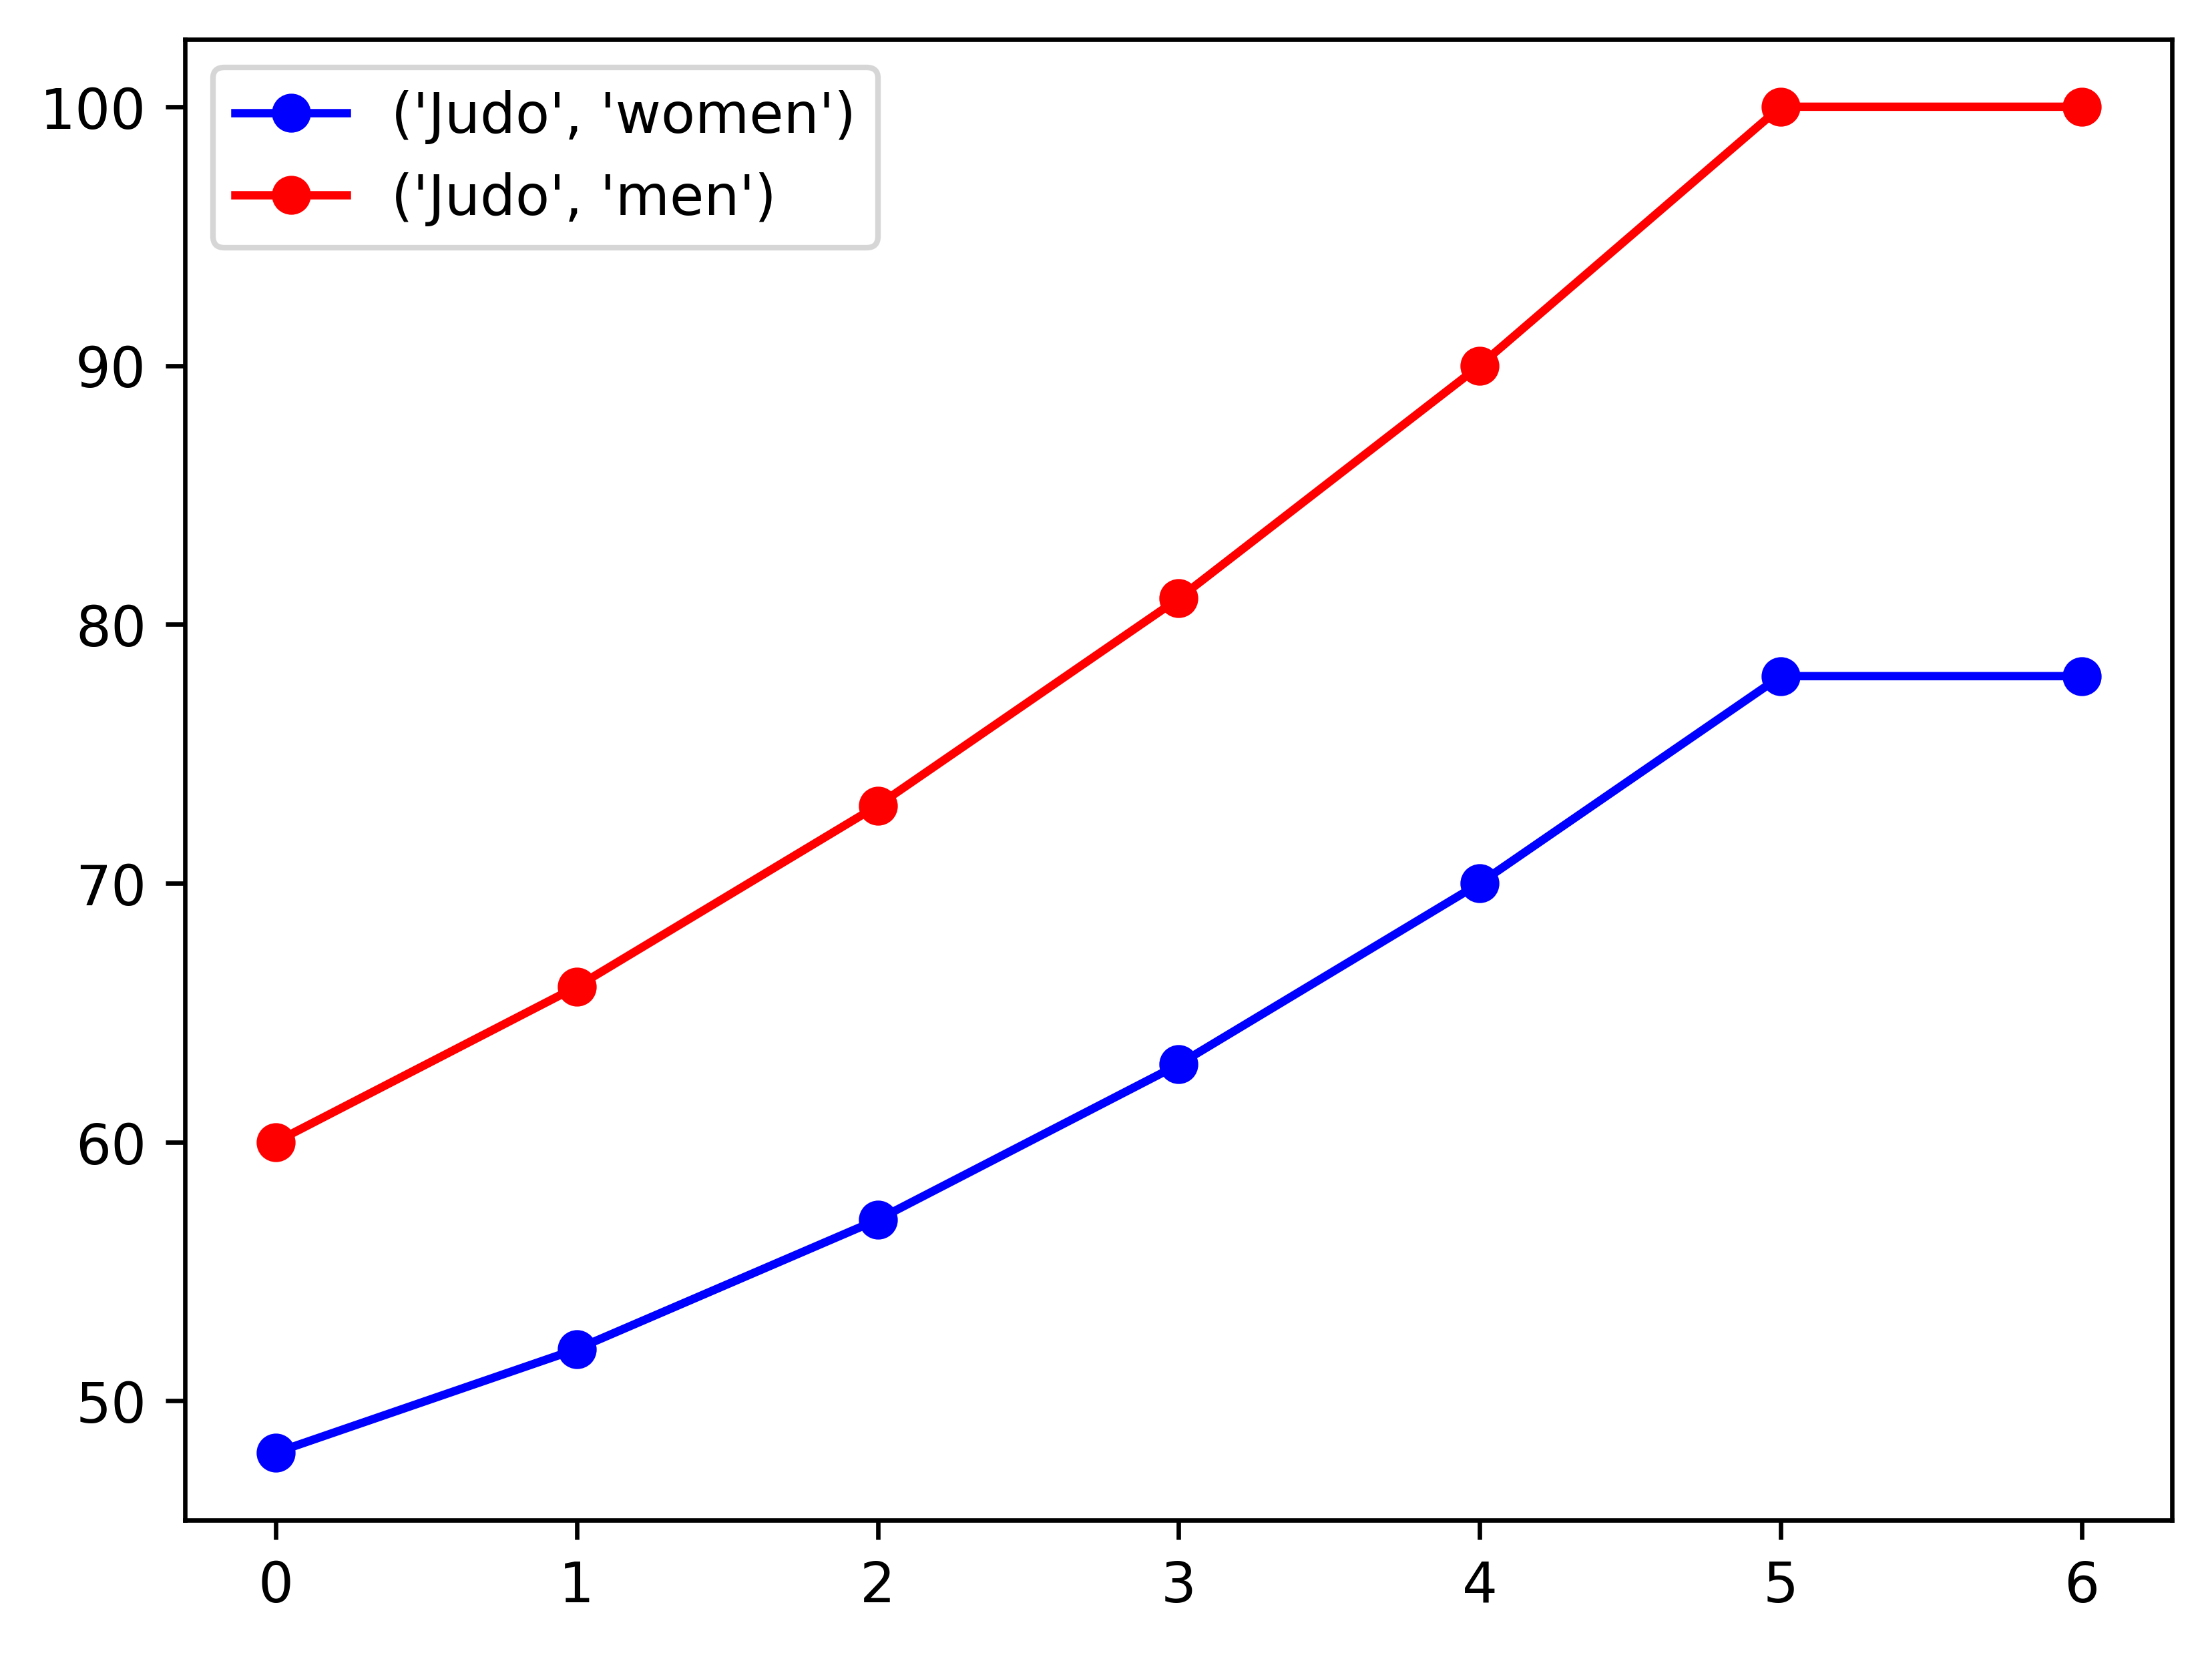

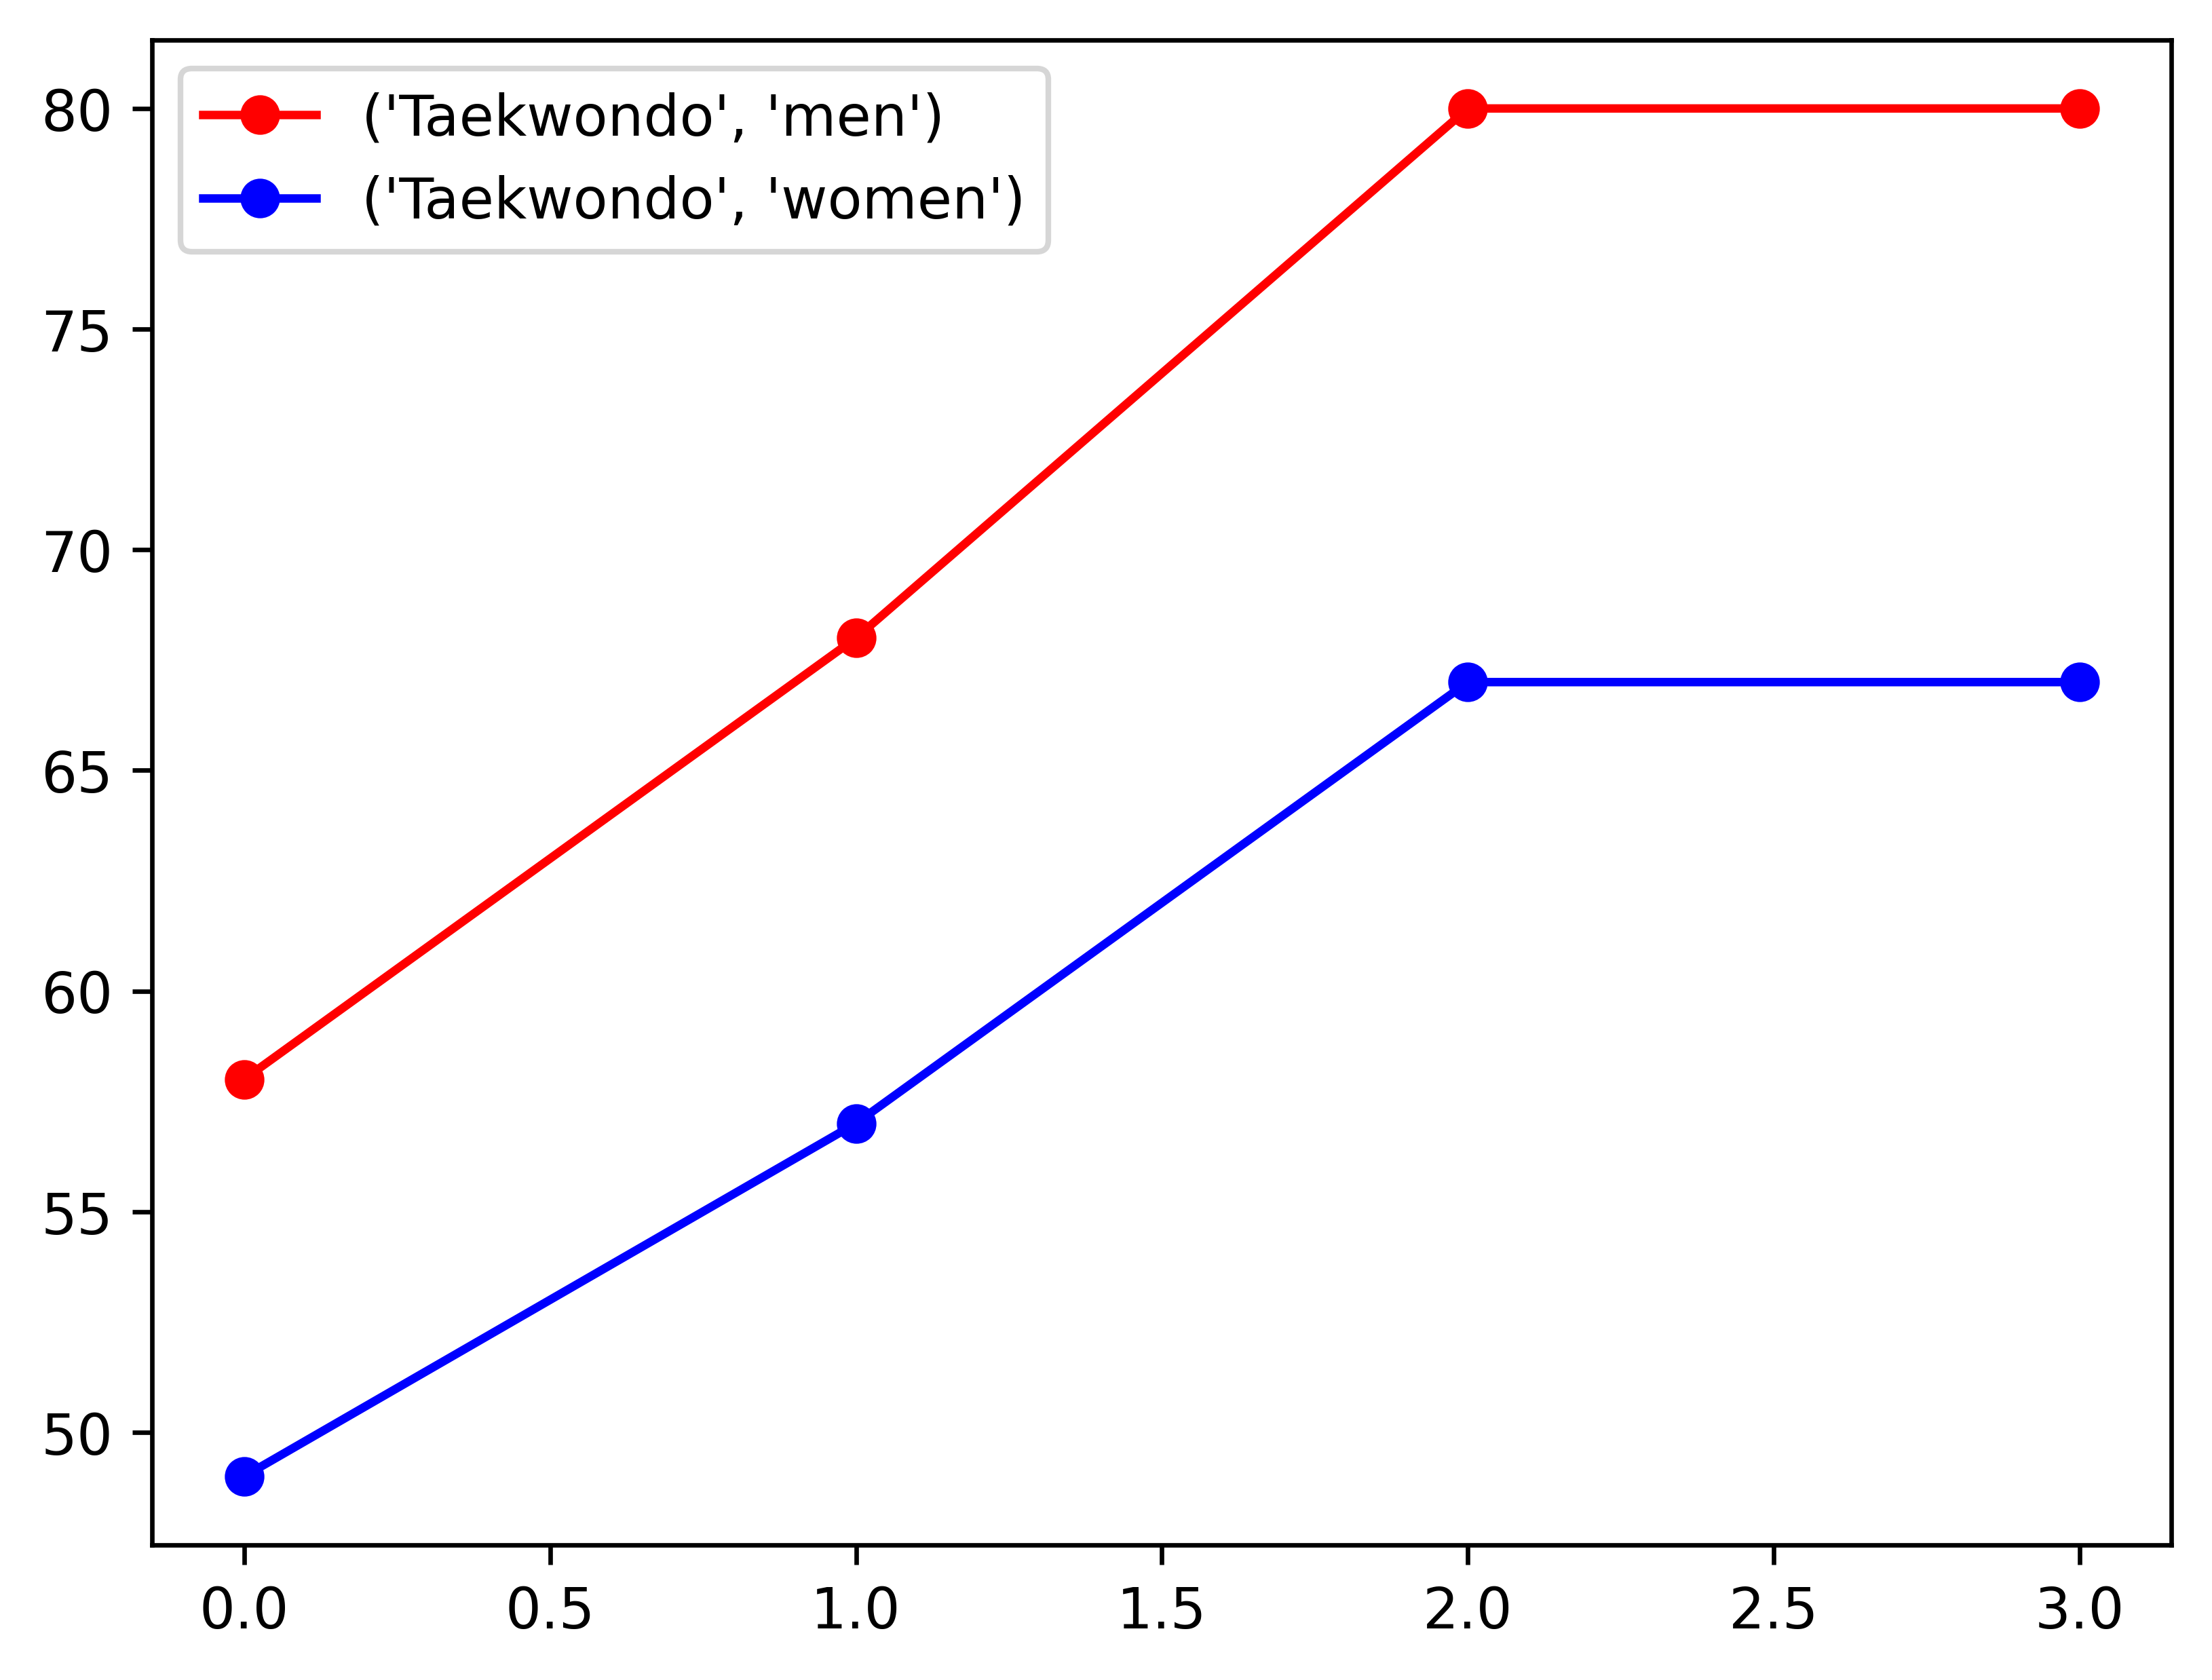

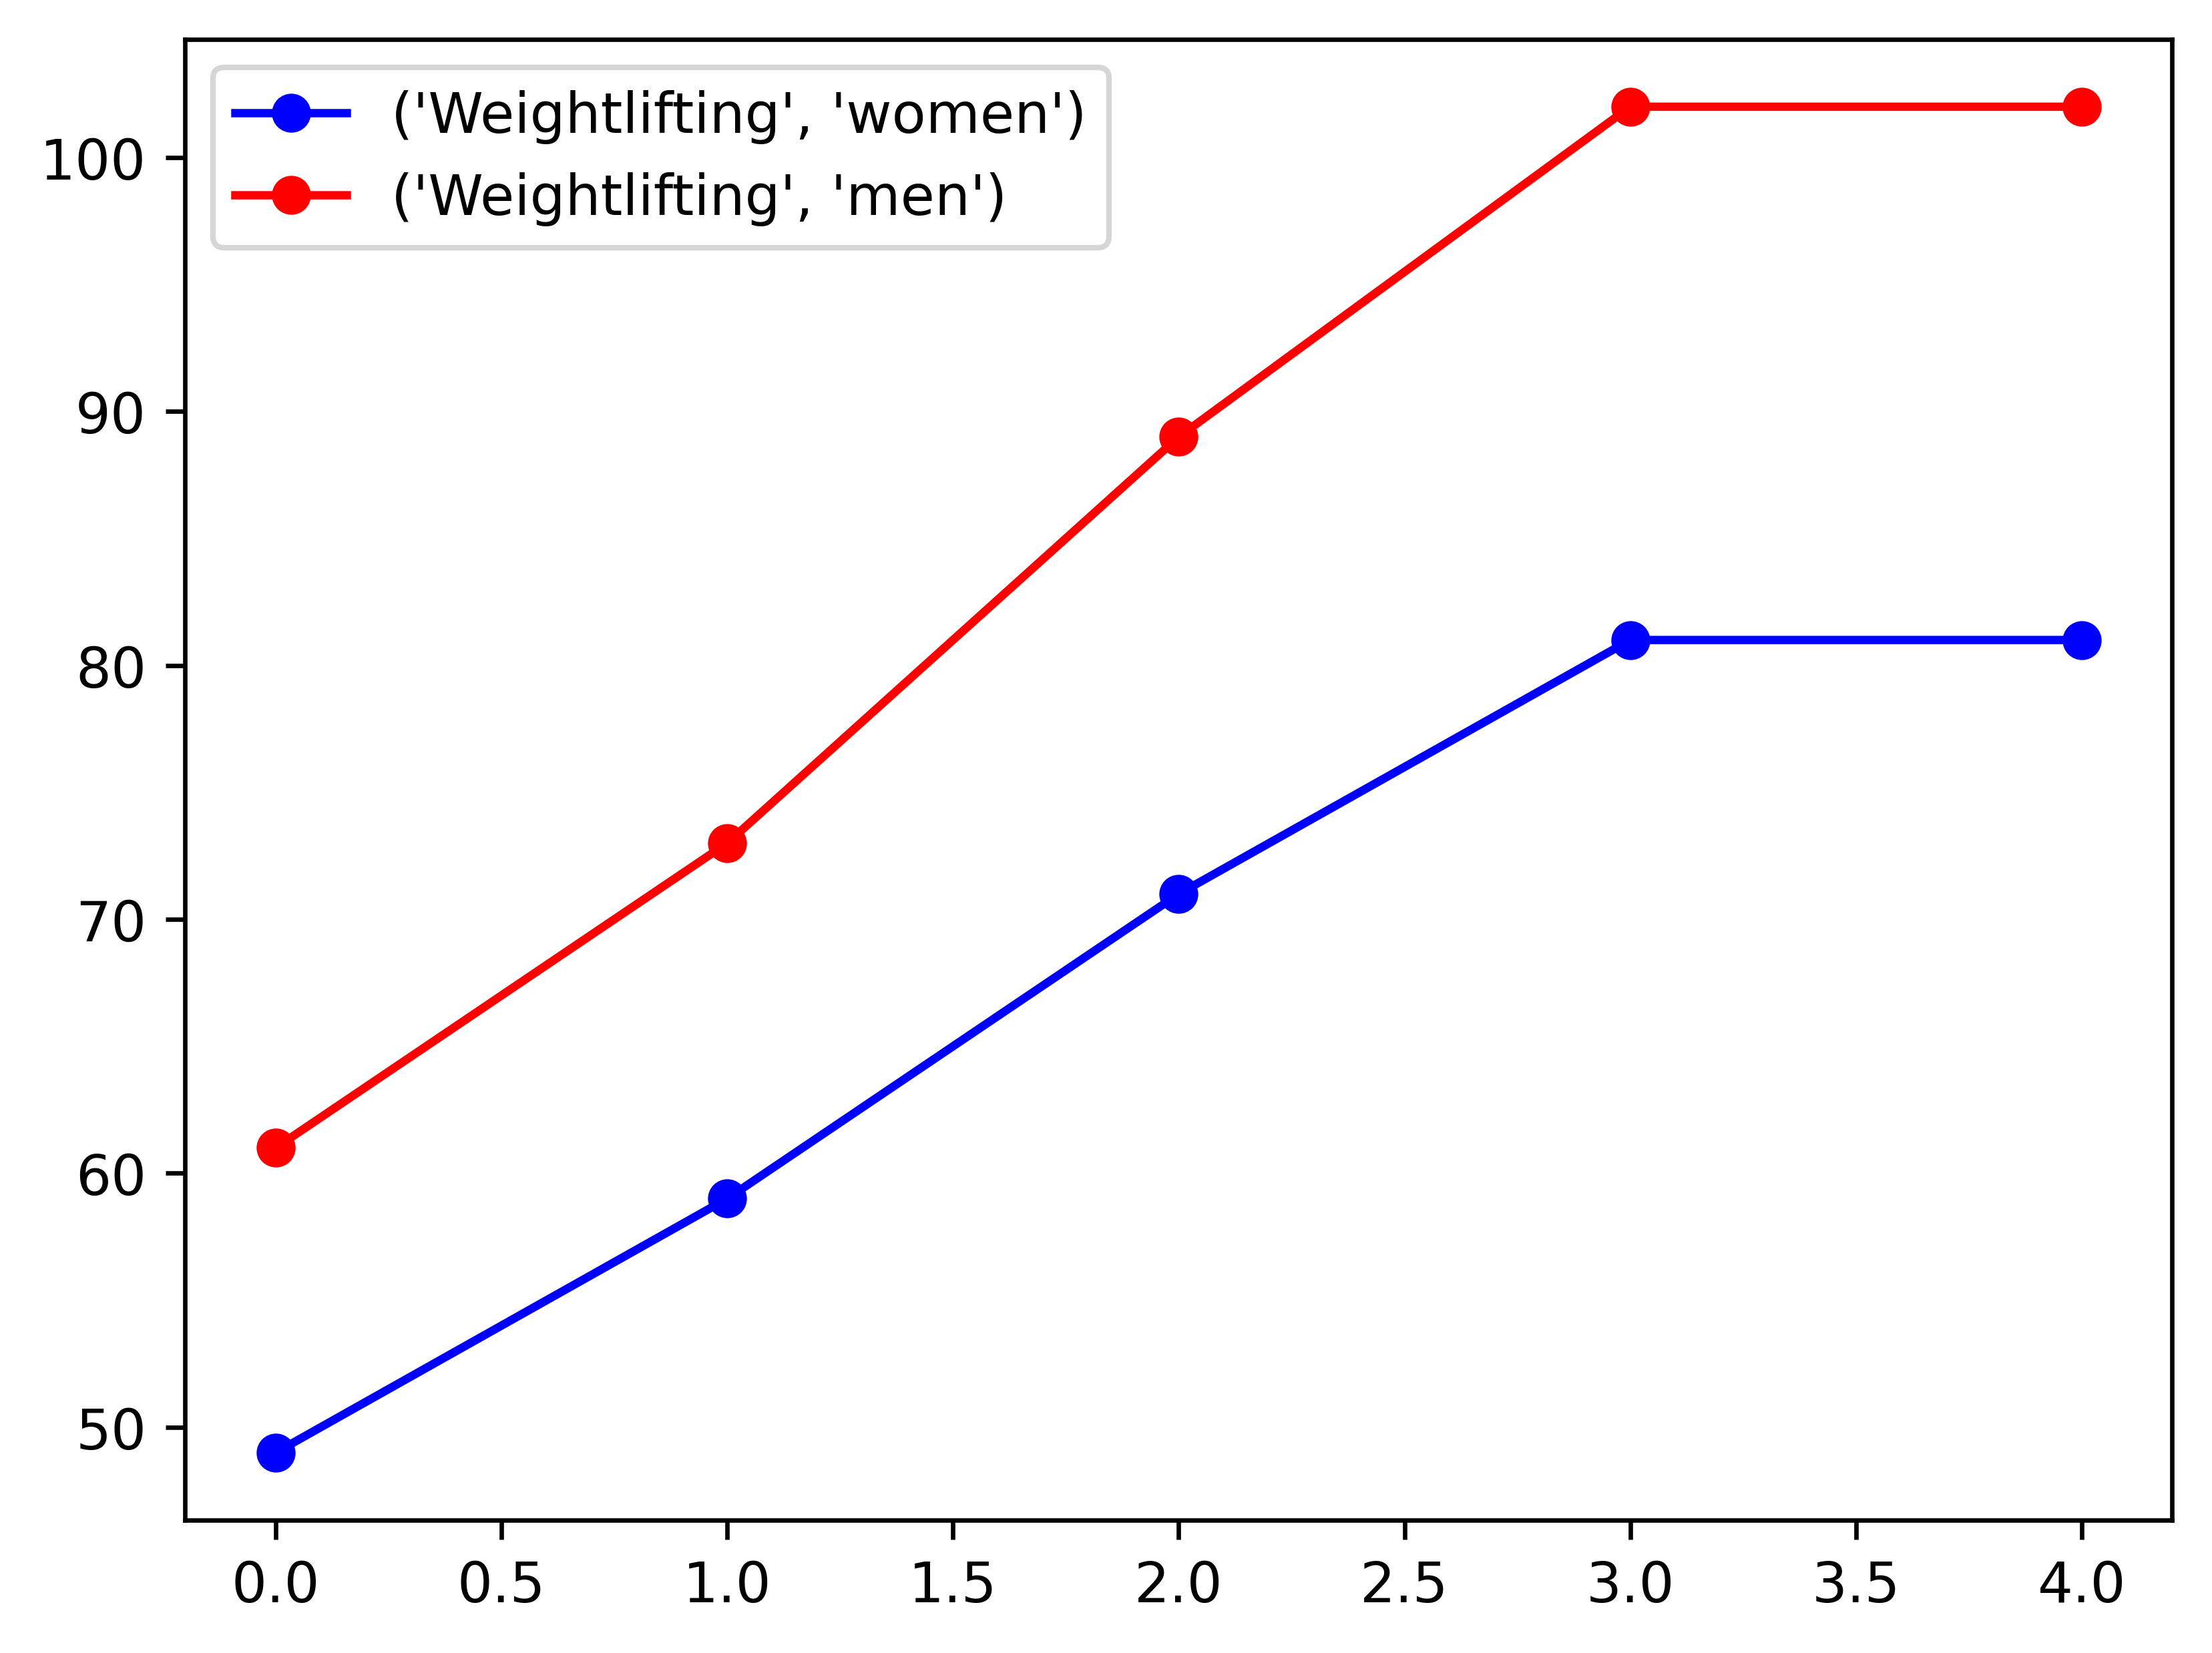

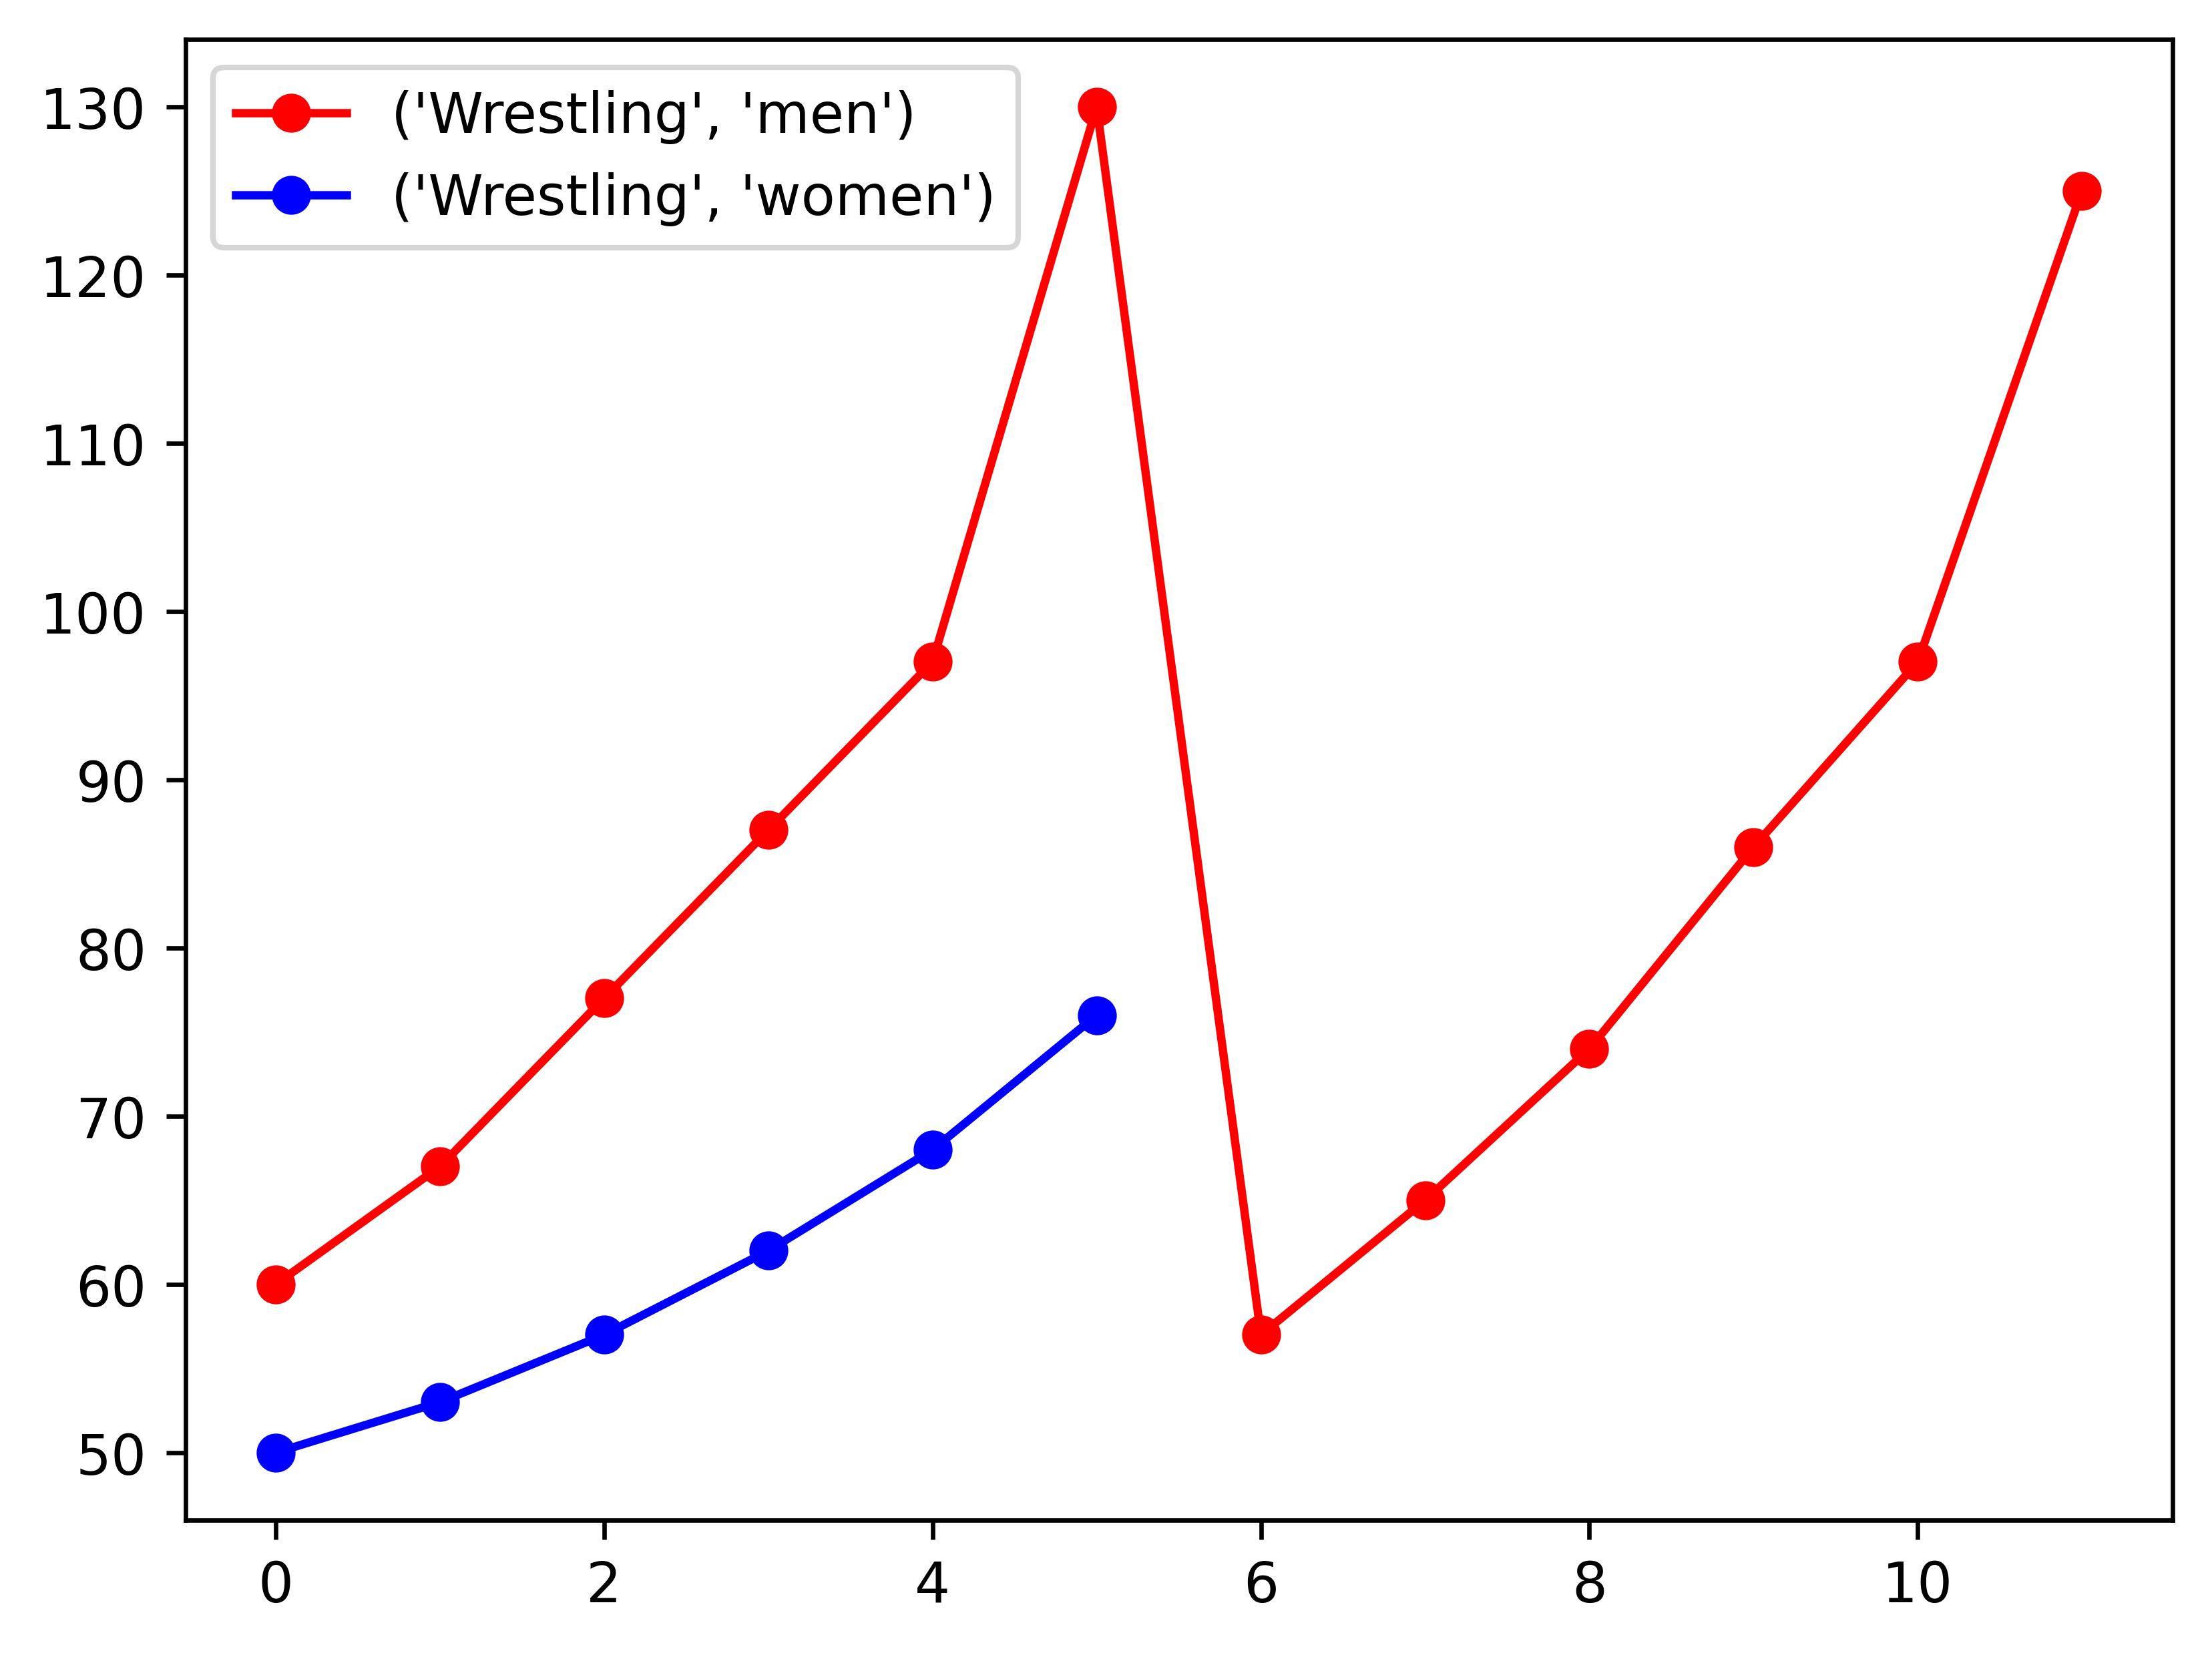

In [83]:
fig, ax = plt.subplots()
color_map = {
    'men': 'red',
    'women': 'blue'
}
unique_indices = weight_df_display.index.unique()
curr_sport = unique_indices[0][0]
curr_sport_count = 0

for unique_sport, gender in unique_indices:
    values = weight_df_display.loc[(unique_sport, gender)].values.flatten()
    if unique_sport != curr_sport:
        fig, ax = plt.subplots()
        curr_sport = unique_sport
        curr_sport_count = 0
    ax.plot(range(len(values)),
            values,
            label = (unique_sport, gender),
            marker = 'o',
            color = color_map[gender],
            linestyle = '-')
    ax.legend(frameon = True)
    curr_sport_count += 1
    
    if curr_sport_count == 2:
        plt.show()

In [84]:
events[events['sport']=='Rhythmic Gymnastics']

event                  tag                sport  \
186  Individual All-Around  rhythmic-gymnastics  Rhythmic Gymnastics   
187       Group All-Around  rhythmic-gymnastics  Rhythmic Gymnastics   

    sport_code                                          sport_url  \
186        GRY  https://olympics.com/en/paris-2024/sports/rhyt...   
187        GRY  https://olympics.com/en/paris-2024/sports/rhyt...   

                 gender  
186  mixed/non-gendered  
187  mixed/non-gendered

In [85]:
events[events['sport']=='Equestrian']

event         tag       sport sport_code  \
141        Eventing Team  equestrian  Equestrian        EQU   
142  Eventing Individual  equestrian  Equestrian        EQU   
143        Dressage Team  equestrian  Equestrian        EQU   
144  Dressage Individual  equestrian  Equestrian        EQU   
145         Jumping Team  equestrian  Equestrian        EQU   
146   Jumping Individual  equestrian  Equestrian        EQU   

                                             sport_url              gender  
141  https://olympics.com/en/paris-2024/sports/eque...  mixed/non-gendered  
142  https://olympics.com/en/paris-2024/sports/eque...  mixed/non-gendered  
143  https://olympics.com/en/paris-2024/sports/eque...  mixed/non-gendered  
144  https://olympics.com/en/paris-2024/sports/eque...  mixed/non-gendered  
145  https://olympics.com/en/paris-2024/sports/eque...  mixed/non-gendered  
146  https://olympics.com/en/paris-2024/sports/eque...  mixed/non-gendered

In [86]:
events[events['sport']=='Artistic Swimming']

event                tag              sport sport_code  \
19  Duet  artistic-swimming  Artistic Swimming        SWA   
20  Team  artistic-swimming  Artistic Swimming        SWA   

                                            sport_url              gender  
19  https://olympics.com/en/paris-2024/sports/arti...  mixed/non-gendered  
20  https://olympics.com/en/paris-2024/sports/arti...  mixed/non-gendered

In [87]:
multi_events = [
    'Archery', 
    'Athletics', 
    'Badminton', 
    'Judo', 
    'Sailing', 
    'Shooting', 
    'Swimming', 
    'Table Tennis', 
    'Tennis', 
    'Triathlon'
]

In [88]:
for event in multi_events:
    display(events[(events['sport']==event)])
    display(events[(events['sport']==event) & (events['gender']=='mixed/non-gendered')])
    print('-'*100)

event      tag    sport sport_code  \
0    Men's Individual  archery  Archery        ARC   
1  Women's Individual  archery  Archery        ARC   
2          Men's Team  archery  Archery        ARC   
3        Women's Team  archery  Archery        ARC   
4          Mixed Team  archery  Archery        ARC   

                                           sport_url              gender  
0  https://olympics.com/en/paris-2024/sports/archery                 men  
1  https://olympics.com/en/paris-2024/sports/archery               women  
2  https://olympics.com/en/paris-2024/sports/archery                 men  
3  https://olympics.com/en/paris-2024/sports/archery               women  
4  https://olympics.com/en/paris-2024/sports/archery  mixed/non-gendered

event      tag    sport sport_code  \
4  Mixed Team  archery  Archery        ARC   

                                           sport_url              gender  
4  https://olympics.com/en/paris-2024/sports/archery  mixed/non-gendered

----------------------------------------------------------------------------------------------------


event        tag      sport sport_code  \
21                      Men's 100m  athletics  Athletics        ATH   
22                      Men's 200m  athletics  Athletics        ATH   
23                      Men's 400m  athletics  Athletics        ATH   
24                      Men's 800m  athletics  Athletics        ATH   
25                     Men's 1500m  athletics  Athletics        ATH   
26                     Men's 5000m  athletics  Athletics        ATH   
27                   Men's 10,000m  athletics  Athletics        ATH   
28                  Men's Marathon  athletics  Athletics        ATH   
29        Men's 3000m Steeplechase  athletics  Athletics        ATH   
30              Men's 110m Hurdles  athletics  Athletics        ATH   
31              Men's 400m Hurdles  athletics  Athletics        ATH   
32                 Men's High Jump  athletics  Athletics        ATH   
33                Men's Pole Vault  athletics  Athletics        ATH   
34                 Men's Long Jump  athletics  Athletics        ATH   
35               Men's Triple Jump  athletics  Athletics        ATH   
36                  Men's Shot Put  athletics  Athletics        ATH   
37              Men's Discus Throw  athletics  Athletics        ATH   
38              Men's Hammer Throw  athletics  Athletics        ATH   
39             Men's Javelin Throw  athletics  Athletics        ATH   
40                 Men's Decathlon  athletics  Athletics        ATH   
41            Men's 20km Race Walk  athletics  Athletics        ATH   
42            Men's 4 x 100m Relay  athletics  Athletics        ATH   
43            Men's 4 x 400m Relay  athletics  Athletics        ATH   
44                    Women's 100m  athletics  Athletics        ATH   
45                    Women's 200m  athletics  Athletics        ATH   
46                    Women's 400m  athletics  Athletics        ATH   
47                    Women's 800m  athletics  Athletics        ATH   
48                   Women's 1500m  athletics  Athletics        ATH   
49                   Women's 5000m  athletics  Athletics        ATH   
50                 Women's 10,000m  athletics  Athletics        ATH   
51                Women's Marathon  athletics  Athletics        ATH   
52      Women's 3000m Steeplechase  athletics  Athletics        ATH   
53            Women's 100m Hurdles  athletics  Athletics        ATH   
54            Women's 400m Hurdles  athletics  Athletics        ATH   
55               Women's High Jump  athletics  Athletics        ATH   
56              Women's Pole Vault  athletics  Athletics        ATH   
57               Women's Long Jump  athletics  Athletics        ATH   
58             Women's Triple Jump  athletics  Athletics        ATH   
59                Women's Shot Put  athletics  Athletics        ATH   
60            Women's Discus Throw  athletics  Athletics        ATH   
61            Women's Hammer Throw  athletics  Athletics        ATH   
62           Women's Javelin Throw  athletics  Athletics        ATH   
63              Women's Heptathlon  athletics  Athletics        ATH   
64          Women's 20km Race Walk  athletics  Athletics        ATH   
65          Women's 4 x 100m Relay  athletics  Athletics        ATH   
66          Women's 4 x 400m Relay  athletics  Athletics        ATH   
67            4 x 400m Relay Mixed  athletics  Athletics        ATH   
68  Marathon Race Walk Mixed Relay  athletics  Athletics        ATH   

                                            sport_url              gender  
21  https://olympics.com/en/paris-2024/sports/athl...                 men  
22  https://olympics.com/en/paris-2024/sports/athl...                 men  
23  https://olympics.com/en/paris-2024/sports/athl...                 men  
24  https://olympics.com/en/paris-2024/sports/athl...                 men  
25  https://olympics.com/en/paris-2024/sports/athl...                 men  
26  https://olympics.com/en/paris-2024/sports/athl...                 men  
27  https://olymp

event        tag      sport sport_code  \
67            4 x 400m Relay Mixed  athletics  Athletics        ATH   
68  Marathon Race Walk Mixed Relay  athletics  Athletics        ATH   

                                            sport_url              gender  
67  https://olympics.com/en/paris-2024/sports/athl...  mixed/non-gendered  
68  https://olympics.com/en/paris-2024/sports/athl...  mixed/non-gendered

----------------------------------------------------------------------------------------------------


event        tag      sport sport_code  \
69    Men's Singles  badminton  Badminton        BDM   
70  Women's Singles  badminton  Badminton        BDM   
71    Men's Doubles  badminton  Badminton        BDM   
72  Women's Doubles  badminton  Badminton        BDM   
73    Mixed Doubles  badminton  Badminton        BDM   

                                            sport_url              gender  
69  https://olympics.com/en/paris-2024/sports/badm...                 men  
70  https://olympics.com/en/paris-2024/sports/badm...               women  
71  https://olympics.com/en/paris-2024/sports/badm...                 men  
72  https://olympics.com/en/paris-2024/sports/badm...               women  
73  https://olympics.com/en/paris-2024/sports/badm...  mixed/non-gendered

event        tag      sport sport_code  \
73  Mixed Doubles  badminton  Badminton        BDM   

                                            sport_url              gender  
73  https://olympics.com/en/paris-2024/sports/badm...  mixed/non-gendered

----------------------------------------------------------------------------------------------------


event   tag sport sport_code  \
167  Women -48 kg  judo  Judo        JUD   
168  Women -52 kg  judo  Judo        JUD   
169  Women -57 kg  judo  Judo        JUD   
170  Women -63 kg  judo  Judo        JUD   
171  Women -70 kg  judo  Judo        JUD   
172  Women -78 kg  judo  Judo        JUD   
173  Women +78 kg  judo  Judo        JUD   
174    Men -60 kg  judo  Judo        JUD   
175    Men -66 kg  judo  Judo        JUD   
176    Men -73 kg  judo  Judo        JUD   
177    Men -81 kg  judo  Judo        JUD   
178    Men -90 kg  judo  Judo        JUD   
179   Men -100 kg  judo  Judo        JUD   
180   Men +100 kg  judo  Judo        JUD   
181    Mixed Team  judo  Judo        JUD   

                                          sport_url              gender  
167  https://olympics.com/en/paris-2024/sports/judo               women  
168  https://olympics.com/en/paris-2024/sports/judo               women  
169  https://olympics.com/en/paris-2024/sports/judo               women  
170  https://olympics.com/en/paris-2024/sports/judo               women  
171  https://olympics.com/en/paris-2024/sports/judo               women  
172  https://olympics.com/en/paris-2024/sports/judo               women  
173  https://olympics.com/en/paris-2024/sports/judo               women  
174  https://olympics.com/en/paris-2024/sports/judo                 men  
175  https://olympics.com/en/paris-2024/sports/judo                 men  
176  https://olympics.com/en/paris-2024/sports/judo                 men  
177  https://olympics.com/en/paris-2024/sports/judo                 men  
178  https://olympics.com/en/paris-2024/sports/judo                 men  
179  https://olympics.com/en/paris-2024/sports/judo                 men  
180  https://olympics.com/en/paris-2024/sports/judo                 men  
181  https://olympics.com/en/paris-2024/sports/judo  mixed/non-gendered

event   tag sport sport_code  \
181  Mixed Team  judo  Judo        JUD   

                                          sport_url              gender  
181  https://olympics.com/en/paris-2024/sports/judo  mixed/non-gendered

----------------------------------------------------------------------------------------------------


event      tag    sport sport_code  \
204    Men's Windsurfing  sailing  Sailing        SAL   
205           Men's Kite  sailing  Sailing        SAL   
206         Men's Dinghy  sailing  Sailing        SAL   
207          Men's Skiff  sailing  Sailing        SAL   
208  Women's Windsurfing  sailing  Sailing        SAL   
209         Women's Kite  sailing  Sailing        SAL   
210       Women's Dinghy  sailing  Sailing        SAL   
211        Women's Skiff  sailing  Sailing        SAL   
212         Mixed Dinghy  sailing  Sailing        SAL   
213      Mixed Multihull  sailing  Sailing        SAL   

                                             sport_url              gender  
204  https://olympics.com/en/paris-2024/sports/sailing                 men  
205  https://olympics.com/en/paris-2024/sports/sailing                 men  
206  https://olympics.com/en/paris-2024/sports/sailing                 men  
207  https://olympics.com/en/paris-2024/sports/sailing                 men  
208  https://olympics.com/en/paris-2024/sports/sailing               women  
209  https://olympics.com/en/paris-2024/sports/sailing               women  
210  https://olympics.com/en/paris-2024/sports/sailing               women  
211  https://olympics.com/en/paris-2024/sports/sailing               women  
212  https://olympics.com/en/paris-2024/sports/sailing  mixed/non-gendered  
213  https://olympics.com/en/paris-2024/sports/sailing  mixed/non-gendered

event      tag    sport sport_code  \
212     Mixed Dinghy  sailing  Sailing        SAL   
213  Mixed Multihull  sailing  Sailing        SAL   

                                             sport_url              gender  
212  https://olympics.com/en/paris-2024/sports/sailing  mixed/non-gendered  
213  https://olympics.com/en/paris-2024/sports/sailing  mixed/non-gendered

----------------------------------------------------------------------------------------------------


event       tag     sport sport_code  \
214            10m Air Rifle Men  shooting  Shooting        SHO   
215    50m Rifle 3 Positions Men  shooting  Shooting        SHO   
216           10m Air Pistol Men  shooting  Shooting        SHO   
217    25m Rapid Fire Pistol Men  shooting  Shooting        SHO   
218                     Trap Men  shooting  Shooting        SHO   
219                    Skeet Men  shooting  Shooting        SHO   
220          10m Air Rifle Women  shooting  Shooting        SHO   
221  50m Rifle 3 Positions Women  shooting  Shooting        SHO   
222         10m Air Pistol Women  shooting  Shooting        SHO   
223             25m Pistol Women  shooting  Shooting        SHO   
224                   Trap Women  shooting  Shooting        SHO   
225                  Skeet Women  shooting  Shooting        SHO   
226     10m Air Rifle Mixed Team  shooting  Shooting        SHO   
227    10m Air Pistol Mixed Team  shooting  Shooting        SHO   
228             Skeet Mixed Team  shooting  Shooting        SHO   

                                             sport_url              gender  
214  https://olympics.com/en/paris-2024/sports/shoo...                 men  
215  https://olympics.com/en/paris-2024/sports/shoo...                 men  
216  https://olympics.com/en/paris-2024/sports/shoo...                 men  
217  https://olympics.com/en/paris-2024/sports/shoo...                 men  
218  https://olympics.com/en/paris-2024/sports/shoo...                 men  
219  https://olympics.com/en/paris-2024/sports/shoo...                 men  
220  https://olympics.com/en/paris-2024/sports/shoo...               women  
221  https://olympics.com/en/paris-2024/sports/shoo...               women  
222  https://olympics.com/en/paris-2024/sports/shoo...               women  
223  https://olympics.com/en/paris-2024/sports/shoo...               women  
224  https://olympics.com/en/paris-2024/sports/shoo...               women  
225  https://olympics.com/en/paris-2024/sports/shoo...               women  
226  https://olympics.com/en/paris-2024/sports/shoo...  mixed/non-gendered  
227  https://olympics.com/en/paris-2024/sports/shoo...  mixed/non-gendered  
228  https://olympics.com/en/paris-2024/sports/shoo...  mixed/non-gendered

event       tag     sport sport_code  \
226   10m Air Rifle Mixed Team  shooting  Shooting        SHO   
227  10m Air Pistol Mixed Team  shooting  Shooting        SHO   
228           Skeet Mixed Team  shooting  Shooting        SHO   

                                             sport_url              gender  
226  https://olympics.com/en/paris-2024/sports/shoo...  mixed/non-gendered  
227  https://olympics.com/en/paris-2024/sports/shoo...  mixed/non-gendered  
228  https://olympics.com/en/paris-2024/sports/shoo...  mixed/non-gendered

----------------------------------------------------------------------------------------------------


event       tag     sport sport_code  \
239             Women's 50m Freestyle  swimming  Swimming        SWM   
240            Women's 100m Freestyle  swimming  Swimming        SWM   
241            Women's 200m Freestyle  swimming  Swimming        SWM   
242            Women's 400m Freestyle  swimming  Swimming        SWM   
243            Women's 800m Freestyle  swimming  Swimming        SWM   
244           Women's 1500m Freestyle  swimming  Swimming        SWM   
245           Women's 100m Backstroke  swimming  Swimming        SWM   
246           Women's 200m Backstroke  swimming  Swimming        SWM   
247         Women's 100m Breaststroke  swimming  Swimming        SWM   
248         Women's 200m Breaststroke  swimming  Swimming        SWM   
249            Women's 100m Butterfly  swimming  Swimming        SWM   
250            Women's 200m Butterfly  swimming  Swimming        SWM   
251    Women's 200m Individual Medley  swimming  Swimming        SWM   
252    Women's 400m Individual Medley  swimming  Swimming        SWM   
253  Women's 4 x 100m Freestyle Relay  swimming  Swimming        SWM   
254  Women's 4 x 200m Freestyle Relay  swimming  Swimming        SWM   
255     Women's 4 x 100m Medley Relay  swimming  Swimming        SWM   
256               Men's 50m Freestyle  swimming  Swimming        SWM   
257              Men's 100m Freestyle  swimming  Swimming        SWM   
258              Men's 200m Freestyle  swimming  Swimming        SWM   
259              Men's 400m Freestyle  swimming  Swimming        SWM   
260              Men's 800m Freestyle  swimming  Swimming        SWM   
261             Men's 1500m Freestyle  swimming  Swimming        SWM   
262             Men's 100m Backstroke  swimming  Swimming        SWM   
263             Men's 200m Backstroke  swimming  Swimming        SWM   
264           Men's 100m Breaststroke  swimming  Swimming        SWM   
265           Men's 200m Breaststroke  swimming  Swimming        SWM   
266              Men's 100m Butterfly  swimming  Swimming        SWM   
267              Men's 200m Butterfly  swimming  Swimming        SWM   
268      Men's 200m Individual Medley  swimming  Swimming        SWM   
269      Men's 400m Individual Medley  swimming  Swimming        SWM   
270    Men's 4 x 100m Freestyle Relay  swimming  Swimming        SWM   
271    Men's 4 x 200m Freestyle Relay  swimming  Swimming        SWM   
272       Men's 4 x 100m Medley Relay  swimming  Swimming        SWM   
273       Mixed 4 x 100m Medley Relay  swimming  Swimming        SWM   

                                             sport_url              gender  
239  https://olympics.com/en/paris-2024/sports/swim...               women  
240  https://olympics.com/en/paris-2024/sports/swim...               women  
241  https://olympics.com/en/paris-2024/sports/swim...               women  
242  https://olympics.com/en/paris-2024/sports/swim...               women  
243  https://olympics.com/en/paris-2024/sports/swim...               women  
244  https://olympics.com/en/paris-2024/sports/swim...               women  
245  https://olympics.com/en/paris-2024/sports/swim...               women  
246  https://olympics.com/en/paris-2024/sports/swim...               women  
247  https://olympics.com/en/paris-2024/sports/swim...               women  
248  https://olympics.com/en/paris-2024/sports/swim...               women  
249  https://olympics.com/en/paris-2024/sports/swim...               women  
250  https://olympics.com/en/paris-2024/sports/swim...               women  
251  https://olympics.com/en/paris-2024/sports/swim...               women  
252  https://olympics.com/en/paris-2024/sports/swim...               women  
253  https://olympics.com/en/paris-2024/sports/swim...               women  
254  https://olympics.com/en/paris-2024/sports/swim...               women  
255  https://olympics.com/en/paris-2024/sports/swim...               women  
256  https://olympics.com/en/paris-2024/sports/swim..

event       tag     sport sport_code  \
273  Mixed 4 x 100m Medley Relay  swimming  Swimming        SWM   

                                             sport_url              gender  
273  https://olympics.com/en/paris-2024/sports/swim...  mixed/non-gendered

----------------------------------------------------------------------------------------------------


event           tag         sport sport_code  \
274    Men's Singles  table-tennis  Table Tennis        TTE   
275  Women's Singles  table-tennis  Table Tennis        TTE   
276    Mixed Doubles  table-tennis  Table Tennis        TTE   
277       Men's Team  table-tennis  Table Tennis        TTE   
278     Women's Team  table-tennis  Table Tennis        TTE   

                                             sport_url              gender  
274  https://olympics.com/en/paris-2024/sports/tabl...                 men  
275  https://olympics.com/en/paris-2024/sports/tabl...               women  
276  https://olympics.com/en/paris-2024/sports/tabl...  mixed/non-gendered  
277  https://olympics.com/en/paris-2024/sports/tabl...                 men  
278  https://olympics.com/en/paris-2024/sports/tabl...               women

event           tag         sport sport_code  \
276  Mixed Doubles  table-tennis  Table Tennis        TTE   

                                             sport_url              gender  
276  https://olympics.com/en/paris-2024/sports/tabl...  mixed/non-gendered

----------------------------------------------------------------------------------------------------


event     tag   sport sport_code  \
287    Men's Singles  tennis  Tennis        TEN   
288  Women's Singles  tennis  Tennis        TEN   
289    Men's Doubles  tennis  Tennis        TEN   
290  Women's Doubles  tennis  Tennis        TEN   
291    Mixed Doubles  tennis  Tennis        TEN   

                                            sport_url              gender  
287  https://olympics.com/en/paris-2024/sports/tennis                 men  
288  https://olympics.com/en/paris-2024/sports/tennis               women  
289  https://olympics.com/en/paris-2024/sports/tennis                 men  
290  https://olympics.com/en/paris-2024/sports/tennis               women  
291  https://olympics.com/en/paris-2024/sports/tennis  mixed/non-gendered

event     tag   sport sport_code  \
291  Mixed Doubles  tennis  Tennis        TEN   

                                            sport_url              gender  
291  https://olympics.com/en/paris-2024/sports/tennis  mixed/non-gendered

----------------------------------------------------------------------------------------------------


event        tag      sport sport_code  \
294  Women's Individual  triathlon  Triathlon        TRI   
295    Men's Individual  triathlon  Triathlon        TRI   
296         Mixed Relay  triathlon  Triathlon        TRI   

                                             sport_url              gender  
294  https://olympics.com/en/paris-2024/sports/tria...               women  
295  https://olympics.com/en/paris-2024/sports/tria...                 men  
296  https://olympics.com/en/paris-2024/sports/tria...  mixed/non-gendered

event        tag      sport sport_code  \
296  Mixed Relay  triathlon  Triathlon        TRI   

                                             sport_url              gender  
296  https://olympics.com/en/paris-2024/sports/tria...  mixed/non-gendered

----------------------------------------------------------------------------------------------------
